# Wolt user segmentation analysis

Addison 2023-02-21

## I. Introduction

This project aims to create a user segmentation for Wolt based on a dataset that contains 21983 rows, each of which displays information of a Wolt customer who has registered to use the service during September 2019 and either has or hasn’t made orders during the time from then and October 2020.

The dataset could be obtained through this link: https://drive.google.com/file/d/1_mIN1zy3CJI7MmpQSL-UC3ZzUanBXLVG/view?usp=share_link


In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import json

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

data = pd.read_csv("dataset_for_analyst_assignment_20201120.csv", 
                   parse_dates=["REGISTRATION_DATE", "FIRST_PURCHASE_DAY", "LAST_PURCHASE_DAY"],
                  dtype={'MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE':'category', 'MOST_COMMON_WEEKDAY_TO_PURCHASE': 'category'  })

## II. Exploring the data

To start with, let's have a quick look at the first few rows as well as essential information about the data to imagine how the data looks like as well as get to know the data types of columns as well as the number of unique and non-null values in each column.

In [2]:
data.head()

,REGISTRATION_DATE,REGISTRATION_COUNTRY,PURCHASE_COUNT,PURCHASE_COUNT_DELIVERY,PURCHASE_COUNT_TAKEAWAY,FIRST_PURCHASE_DAY,LAST_PURCHASE_DAY,USER_ID,BREAKFAST_PURCHASES,LUNCH_PURCHASES,...,WEB_PURCHASES,ANDROID_PURCHASES,PREFERRED_RESTAURANT_TYPES,USER_HAS_VALID_PAYMENT_METHOD,MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE,MOST_COMMON_WEEKDAY_TO_PURCHASE,AVG_DAYS_BETWEEN_PURCHASES,MEDIAN_DAYS_BETWEEN_PURCHASES,AVERAGE_DELIVERY_DISTANCE_KMS,PURCHASE_COUNT_BY_STORE_TYPE
0,2019-09-01,DNK,0,NaN,NaN,NaT,NaT,1,NaN,NaN,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
1,2019-09-01,FIN,1,1.0,0.0,2020-09-02,2020-09-02,2,0.0,1.0,...,0.0,1.0,NaN,False,23,2,NaN,NaN,6.853,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
2,2019-09-01,DNK,19,19.0,0.0,2019-12-10,2020-05-25,3,0.0,4.0,...,19.0,0.0,NaN,True,21,2,9.0,3.0,6.559,"{\n ""General merchandise"": 1,\n ""Grocery"": 9..."
3,2019-09-01,FIN,0,NaN,NaN,NaT,NaT,4,NaN,NaN,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
4,2019-09-01,GRC,0,NaN,NaN,NaT,NaT,5,NaN,NaN,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21983 entries, 0 to 21982
Data columns (total 30 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   REGISTRATION_DATE                        21983 non-null  datetime64[ns]
 1   REGISTRATION_COUNTRY                     21983 non-null  object        
 2   PURCHASE_COUNT                           21983 non-null  int64         
 3   PURCHASE_COUNT_DELIVERY                  12028 non-null  float64       
 4   PURCHASE_COUNT_TAKEAWAY                  12028 non-null  float64       
 5   FIRST_PURCHASE_DAY                       11964 non-null  datetime64[ns]
 6   LAST_PURCHASE_DAY                        12027 non-null  datetime64[ns]
 7   USER_ID                                  21983 non-null  int64         
 8   BREAKFAST_PURCHASES                      12028 non-null  float64       
 9   LUNCH_PURCHASES                        

In [4]:
data.nunique()

REGISTRATION_DATE                             30
REGISTRATION_COUNTRY                          59
PURCHASE_COUNT                               107
PURCHASE_COUNT_DELIVERY                      106
PURCHASE_COUNT_TAKEAWAY                       26
FIRST_PURCHASE_DAY                           426
LAST_PURCHASE_DAY                            427
USER_ID                                    21983
BREAKFAST_PURCHASES                           22
LUNCH_PURCHASES                               67
EVENING_PURCHASES                             31
DINNER_PURCHASES                              57
LATE_NIGHT_PURCHASES                           1
TOTAL_PURCHASES_EUR                         1088
DISTINCT_PURCHASE_VENUE_COUNT                 40
MIN_PURCHASE_VALUE_EUR                       153
MAX_PURCHASE_VALUE_EUR                       224
AVG_PURCHASE_VALUE_EUR                       168
PREFERRED_DEVICE                               3
IOS_PURCHASES                                 79
WEB_PURCHASES       

Now, we will examine the correlation between the numeric variables.

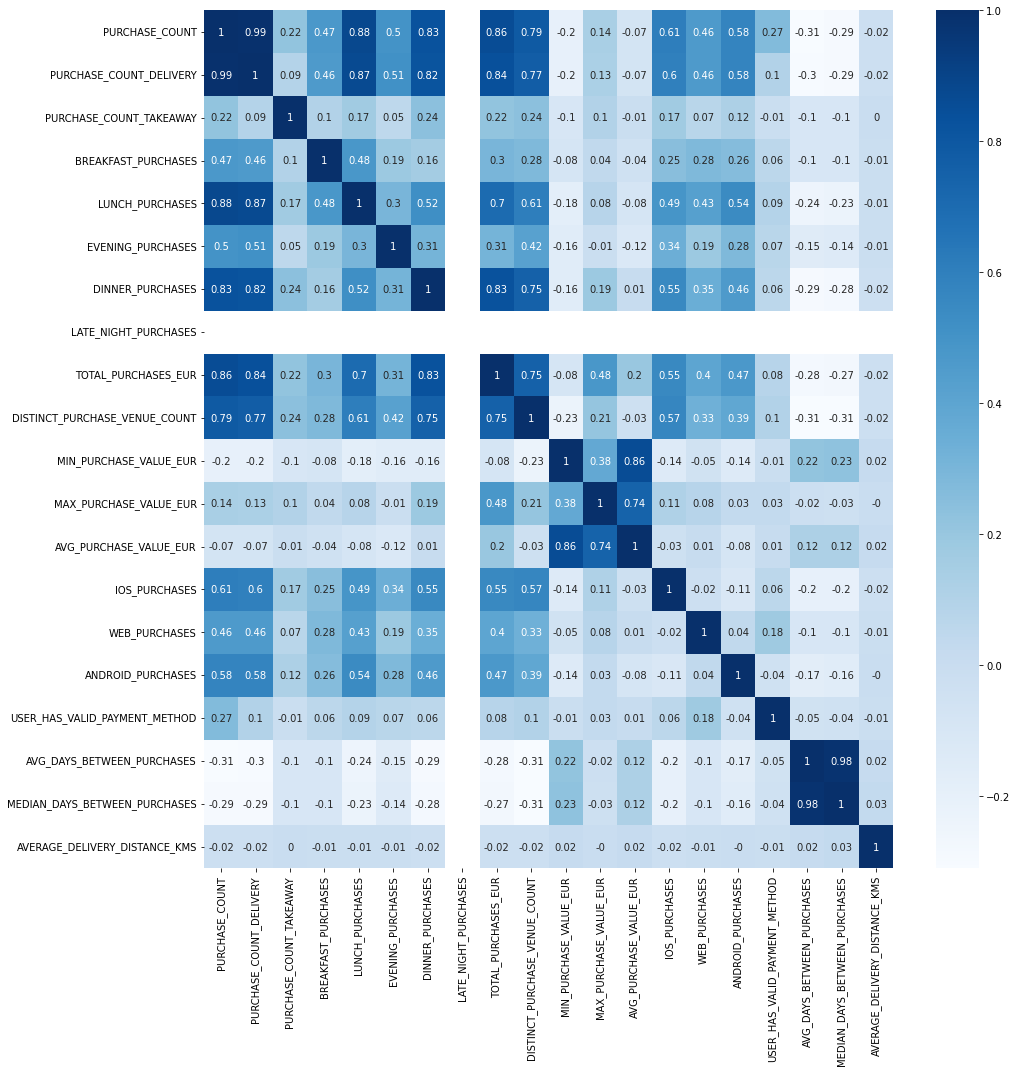

In [5]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(round(data.drop('USER_ID', axis=1).corr(), 2), cmap='Blues', annot=True, ax=ax)

plt.tight_layout()
plt.show()

In [6]:
data["LATE_NIGHT_PURCHASES"].value_counts()

0.0    12028
Name: LATE_NIGHT_PURCHASES, dtype: int64

We notice that the column **LATE_NIGHT_PURCHASES** has either null values or values of 0. Since these values have no clear differences as well as the correlation plot shows no correlation between this column and the others, we are going to delete it.

In [7]:
data.drop(['LATE_NIGHT_PURCHASES'], axis=1, inplace = True)

Now, we are going to calculate the number of null values in each column.

In [8]:
data.isnull().sum()

REGISTRATION_DATE                              0
REGISTRATION_COUNTRY                           0
PURCHASE_COUNT                                 0
PURCHASE_COUNT_DELIVERY                     9955
PURCHASE_COUNT_TAKEAWAY                     9955
FIRST_PURCHASE_DAY                         10019
LAST_PURCHASE_DAY                           9956
USER_ID                                        0
BREAKFAST_PURCHASES                         9955
LUNCH_PURCHASES                             9955
EVENING_PURCHASES                           9955
DINNER_PURCHASES                            9955
TOTAL_PURCHASES_EUR                         9955
DISTINCT_PURCHASE_VENUE_COUNT               9955
MIN_PURCHASE_VALUE_EUR                      9955
MAX_PURCHASE_VALUE_EUR                      9955
AVG_PURCHASE_VALUE_EUR                      9955
PREFERRED_DEVICE                              73
IOS_PURCHASES                               9955
WEB_PURCHASES                               9955
ANDROID_PURCHASES   

## III. Examining users whose purchase_count = 0
Since we notice that many columns have the same number of null values (9955), we can make an educated guess that these columns have null values on the same rows. Thus, we will filter the data with a condition that one of these columns is null and then calculate the number of null values in each column in this dataset slice to check the accuracy of our guess.

In [9]:
data_0 = data[data["PURCHASE_COUNT_DELIVERY"].isna()]
data_0.head()

,REGISTRATION_DATE,REGISTRATION_COUNTRY,PURCHASE_COUNT,PURCHASE_COUNT_DELIVERY,PURCHASE_COUNT_TAKEAWAY,FIRST_PURCHASE_DAY,LAST_PURCHASE_DAY,USER_ID,BREAKFAST_PURCHASES,LUNCH_PURCHASES,...,WEB_PURCHASES,ANDROID_PURCHASES,PREFERRED_RESTAURANT_TYPES,USER_HAS_VALID_PAYMENT_METHOD,MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE,MOST_COMMON_WEEKDAY_TO_PURCHASE,AVG_DAYS_BETWEEN_PURCHASES,MEDIAN_DAYS_BETWEEN_PURCHASES,AVERAGE_DELIVERY_DISTANCE_KMS,PURCHASE_COUNT_BY_STORE_TYPE
0,2019-09-01,DNK,0,NaN,NaN,NaT,NaT,1,NaN,NaN,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
3,2019-09-01,FIN,0,NaN,NaN,NaT,NaT,4,NaN,NaN,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
4,2019-09-01,GRC,0,NaN,NaN,NaT,NaT,5,NaN,NaN,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
5,2019-09-01,FIN,0,NaN,NaN,NaT,NaT,6,NaN,NaN,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
6,2019-09-01,DNK,0,NaN,NaN,NaT,NaT,7,NaN,NaN,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."


In [10]:
data_0.isnull().sum()

REGISTRATION_DATE                             0
REGISTRATION_COUNTRY                          0
PURCHASE_COUNT                                0
PURCHASE_COUNT_DELIVERY                    9955
PURCHASE_COUNT_TAKEAWAY                    9955
FIRST_PURCHASE_DAY                         9955
LAST_PURCHASE_DAY                          9955
USER_ID                                       0
BREAKFAST_PURCHASES                        9955
LUNCH_PURCHASES                            9955
EVENING_PURCHASES                          9955
DINNER_PURCHASES                           9955
TOTAL_PURCHASES_EUR                        9955
DISTINCT_PURCHASE_VENUE_COUNT              9955
MIN_PURCHASE_VALUE_EUR                     9955
MAX_PURCHASE_VALUE_EUR                     9955
AVG_PURCHASE_VALUE_EUR                     9955
PREFERRED_DEVICE                             72
IOS_PURCHASES                              9955
WEB_PURCHASES                              9955
ANDROID_PURCHASES                       

In [11]:
len(data_0)

9955

Since the number of null values in the columns that we doubted null values are on the same rows are unchanged and equal to the length of the dataset slice, we can confirm that these columns have null values on the same rows.

Now, we will examine the number of unique values in each column of this subdataset.

In [12]:
data_0.nunique()

REGISTRATION_DATE                            30
REGISTRATION_COUNTRY                         59
PURCHASE_COUNT                                1
PURCHASE_COUNT_DELIVERY                       0
PURCHASE_COUNT_TAKEAWAY                       0
FIRST_PURCHASE_DAY                            0
LAST_PURCHASE_DAY                             0
USER_ID                                    9955
BREAKFAST_PURCHASES                           0
LUNCH_PURCHASES                               0
EVENING_PURCHASES                             0
DINNER_PURCHASES                              0
TOTAL_PURCHASES_EUR                           0
DISTINCT_PURCHASE_VENUE_COUNT                 0
MIN_PURCHASE_VALUE_EUR                        0
MAX_PURCHASE_VALUE_EUR                        0
AVG_PURCHASE_VALUE_EUR                        0
PREFERRED_DEVICE                              3
IOS_PURCHASES                                 0
WEB_PURCHASES                                 0
ANDROID_PURCHASES                       

### 3.1 Choosing features
From the tables above, we can see the patterns of this subdataset: 

**1. All users have purchase_count = 0**

**2. The proportion of non-null values of each column is either 100% or below 1%**

Thus, we will retain only the columns whose proportion of non-null values is below 1%. It is also worth noting that we won't include the **USER_ID** column for the user segmentation purpose, the **PURCHASE_COUNT** or **PURCHASE_COUNT_BY_STORE_TYPE** columns because the statistics in these columns for all the users in this subdataset have the same number of 0.

For transparency, here are the columns we will use to segment the users who did not make any orders between September 2019 and October 2020.

**1. REGISTRATION_DATE**

**2. REGISTRATION_COUNTRY**

**3. PREFERRED_DEVICE**

**4. USER_HAS_VALID_PAYMENT_METHOD**

In [13]:
data_0_condensed = data_0.loc[:,["REGISTRATION_DATE", "REGISTRATION_COUNTRY","PREFERRED_DEVICE", "USER_HAS_VALID_PAYMENT_METHOD"]]
data_0_condensed.head()

,REGISTRATION_DATE,REGISTRATION_COUNTRY,PREFERRED_DEVICE,USER_HAS_VALID_PAYMENT_METHOD
0,2019-09-01,DNK,ios,False
3,2019-09-01,FIN,android,False
4,2019-09-01,GRC,android,False
5,2019-09-01,FIN,android,False
6,2019-09-01,DNK,ios,False


### 3.2 Transforming data
Now, we are going to replace True and False values in the **USER_HAS_VALID_PAYMENT_METHOD** column with 1 and 0 respectively for the segmentation purpose.

In [14]:
data_0_condensed.replace({False:0, True:1}, inplace = True)
data_0_condensed.head()

,REGISTRATION_DATE,REGISTRATION_COUNTRY,PREFERRED_DEVICE,USER_HAS_VALID_PAYMENT_METHOD
0,2019-09-01,DNK,ios,0
3,2019-09-01,FIN,android,0
4,2019-09-01,GRC,android,0
5,2019-09-01,FIN,android,0
6,2019-09-01,DNK,ios,0


Next, we will create a new column named **REGISTRATION_RECENCY** to determine how recently a customer has registered since the latest recorded registration date. Values in this column result from the latest **REGISTRATION_DATE** minus the corresponding **REGISTRATION_DATE** in each row.

In [15]:
data_0_condensed["REGISTRATION_RECENCY"] = (max(data_0_condensed["REGISTRATION_DATE"]) - data_0_condensed["REGISTRATION_DATE"]).dt.days
data_0_condensed.head()

,REGISTRATION_DATE,REGISTRATION_COUNTRY,PREFERRED_DEVICE,USER_HAS_VALID_PAYMENT_METHOD,REGISTRATION_RECENCY
0,2019-09-01,DNK,ios,0,29
3,2019-09-01,FIN,android,0,29
4,2019-09-01,GRC,android,0,29
5,2019-09-01,FIN,android,0,29
6,2019-09-01,DNK,ios,0,29


In [16]:
data_0_condensed.isnull().sum()

REGISTRATION_DATE                 0
REGISTRATION_COUNTRY              0
PREFERRED_DEVICE                 72
USER_HAS_VALID_PAYMENT_METHOD     0
REGISTRATION_RECENCY              0
dtype: int64

Now, we are going to dummy-code the **REGISTRATION_COUNTRY** and **PREFERRED_DEVICE** columns including null values in the **PREFERRED_DEVICE** column since these columns are non-numerical.
We also will delete the **'REGISTRATION_DATE','REGISTRATION_COUNTRY','PREFERRED_DEVICE'** columns after that for the segmentation purpose.

In [17]:
dummies_1 = pd.get_dummies(data_0_condensed[['REGISTRATION_COUNTRY']], drop_first=True)
dummies_2 = pd.get_dummies(data_0_condensed[['PREFERRED_DEVICE']], drop_first=True, dummy_na = True)

data_0_condensed_dummies = pd.concat([data_0_condensed, dummies_1, dummies_2], axis=1)
data_0_condensed_dummies.drop(['REGISTRATION_DATE','REGISTRATION_COUNTRY','PREFERRED_DEVICE'], axis=1, inplace=True)
data_0_condensed_dummies.head()

,USER_HAS_VALID_PAYMENT_METHOD,REGISTRATION_RECENCY,REGISTRATION_COUNTRY_AUS,REGISTRATION_COUNTRY_AUT,REGISTRATION_COUNTRY_AZE,REGISTRATION_COUNTRY_BEL,REGISTRATION_COUNTRY_BRA,REGISTRATION_COUNTRY_CAN,REGISTRATION_COUNTRY_CHE,REGISTRATION_COUNTRY_CHL,...,REGISTRATION_COUNTRY_SVK,REGISTRATION_COUNTRY_SVN,REGISTRATION_COUNTRY_SWE,REGISTRATION_COUNTRY_TUR,REGISTRATION_COUNTRY_TWN,REGISTRATION_COUNTRY_UKR,REGISTRATION_COUNTRY_USA,PREFERRED_DEVICE_ios,PREFERRED_DEVICE_web,PREFERRED_DEVICE_nan
0,0,29,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,29,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,29,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,29,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,29,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### 3.3 Scaling data
After making the whole subdataset numerical, we will standardize it.

In [97]:
scaler = StandardScaler()
scaler.fit(data_0_condensed_dummies)

data_0_condensed_dummies_scaled = scaler.transform(data_0_condensed_dummies)


### 3.4 Choosing K
Now, we are going to run the k-means algorithm considering a range from 1 to 10 and plot the elbow curve to find the optimal the number of clusters K.

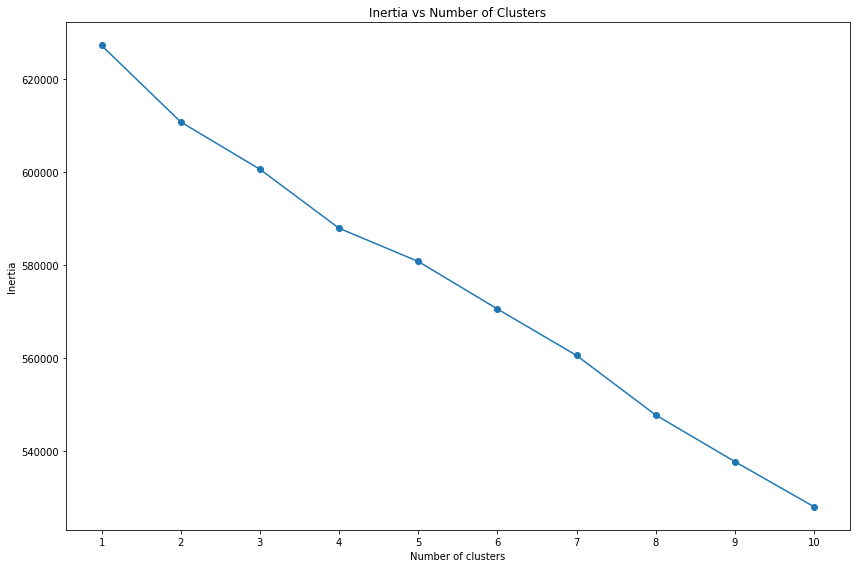

In [98]:
X = pd.DataFrame(data_0_condensed_dummies_scaled)
inertias = []

for k in range(1, 11):
    model = KMeans(n_clusters=k)
    y = model.fit_predict(X)
    inertias.append(model.inertia_)
    
plt.figure(figsize=(12, 8))
plt.plot(range(1, 11), inertias, marker='o')
plt.xticks(ticks=range(1, 11), labels=range(1, 11))
plt.title('Inertia vs Number of Clusters')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")

plt.tight_layout()
plt.show()

It looks like the rate of decreasing of the inertia slows down between 3 and 5 clusters. We'll use 3 clusters to move on.

In [99]:

model = KMeans(n_clusters=3)
y = model.fit_predict(data_0_condensed_dummies_scaled)

y

array([0, 1, 2, ..., 2, 0, 0], dtype=int32)

### 3.5 Analyzing data
After performing clustering over the subdataset, we will create a column named **CLUSTER** to label the cluster for each user.

In [100]:
data_0_condensed['CLUSTER'] = y + 1
data_0_condensed.head()

,REGISTRATION_DATE,REGISTRATION_COUNTRY,PREFERRED_DEVICE,USER_HAS_VALID_PAYMENT_METHOD,REGISTRATION_RECENCY,CLUSTER
0,2019-09-01,DNK,ios,0,29,1
3,2019-09-01,FIN,android,0,29,2
4,2019-09-01,GRC,android,0,29,3
5,2019-09-01,FIN,android,0,29,2
6,2019-09-01,DNK,ios,0,29,1


Next, we will calculate the number of users per cluster.

In [101]:
data_0_condensed['CLUSTER'].value_counts()

2    4998
1    3440
3    1517
Name: CLUSTER, dtype: int64

In [102]:
data_0_condensed[data_0_condensed['CLUSTER']==3]["REGISTRATION_COUNTRY"].value_counts()

GRC    1510
SGP       4
COL       2
PAK       1
Name: REGISTRATION_COUNTRY, dtype: int64

We will also find out the number of users per registration country for the purpose of visualization later.

In [103]:
data_0_condensed['REGISTRATION_COUNTRY'].value_counts(ascending = False)

FIN    4826
DNK    3096
GRC    1510
USA      70
GBR      52
SWE      41
DEU      38
EST      31
ITA      24
NOR      21
LTU      20
ESP      19
POL      19
AUS      11
BEL      11
NLD      10
CZE      10
FRA       9
RUS       8
IND       7
BRA       7
IRL       7
QAT       6
HUN       6
CYP       6
JPN       6
ISR       6
PRT       5
ROU       5
CAN       5
AUT       5
ARE       5
CHE       4
LVA       4
SGP       4
HRV       4
FRO       3
CHN       3
SVK       3
UKR       2
LBN       2
JOR       2
CHL       2
TUR       2
AZE       2
ISL       2
COL       2
SAU       1
PHL       1
KOR       1
PAK       1
TWN       1
GEO       1
MEX       1
HKG       1
GIN       1
KWT       1
MLT       1
SVN       1
Name: REGISTRATION_COUNTRY, dtype: int64

Next, we will plot the average value of each numeric variable per cluster.

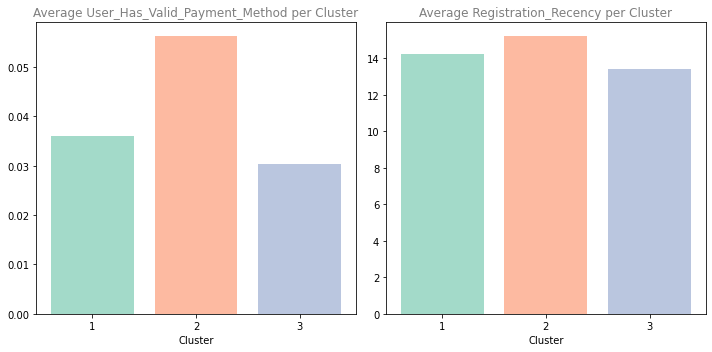

In [104]:
numeric_columns = data_0_condensed.select_dtypes(include=np.number).drop(['CLUSTER'], axis=1).columns

fig = plt.figure(figsize=(10, 5))
for i, column in enumerate(numeric_columns):
    df_plot = data_0_condensed.groupby('CLUSTER')[column].mean()
    ax = fig.add_subplot(1, 2, i+1)

    ax.bar(df_plot.index, df_plot, color=sns.color_palette("Set2"), alpha=0.6)
    ax.set_title(f'Average {column.title()} per Cluster', alpha=0.5)
    ax.xaxis.grid(False)
    plt.xlabel("Cluster")
    plt.xticks(ticks=range(1, 4), labels=range(1, 4))


    
plt.tight_layout()
plt.show()

For the categorical columns, we will plot the percentual distribution of each variable in each cluster. It is also worth noting that the chart will only display the legend of the top 3 registration countries for better visualization.

/var/folders/tl/svtqjw_s0kn4lpthrk3xjwpr0000gn/T/ipykernel_5877/3550646651.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(labels)
/var/folders/tl/svtqjw_s0kn4lpthrk3xjwpr0000gn/T/ipykernel_5877/3550646651.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(labels)


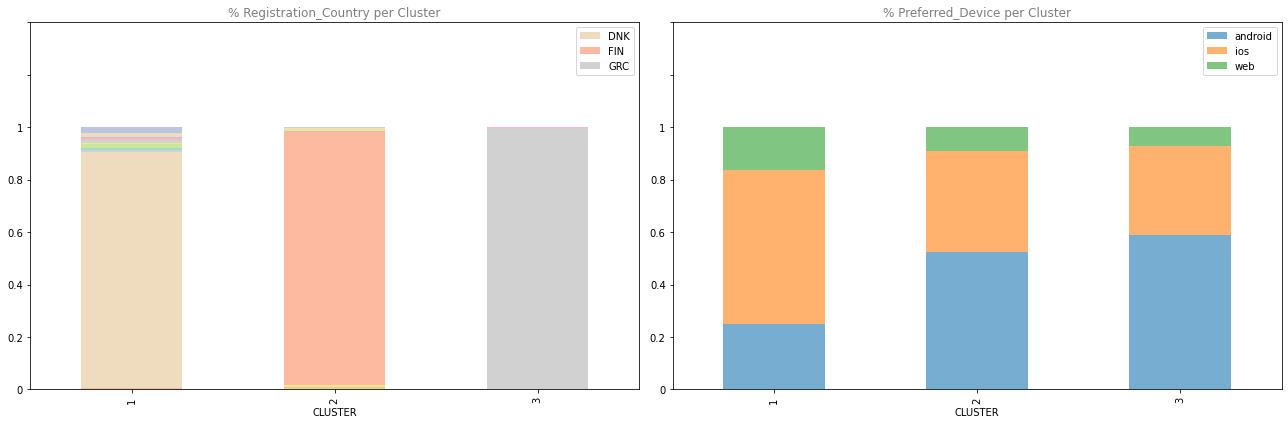

In [105]:
cat_column_1 = ['REGISTRATION_COUNTRY']

cat_column_2 = ['PREFERRED_DEVICE']


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,
                                        figsize=(18,6))

for i, col in enumerate(cat_column_1):
    plot_df = pd.crosstab(index=data_0_condensed['CLUSTER'], columns=data_0_condensed[col], values=data_0_condensed[col], aggfunc='size', normalize='index')
    plot_df.plot.bar(stacked=True, ax=ax1, alpha=0.6, color=sns.color_palette("Set2"))
    ax1.set_title(f'% {col.title()} per Cluster', alpha=0.5)
    
    handle, label = ax1.get_legend_handles_labels()
    
    chosen_country = [14,17, 23]
    major_handle = [handle[t] for t in chosen_country]
    major_label = [label[t] for t in chosen_country]
    
    ax1.legend(major_handle, major_label)
 
    ax1.set_ylim(0, 1.4)
    ax1.xaxis.grid(False)
   
    labels = [0, 0.2, 0.4, 0.6, 0.8, 1]
    ax1.set_yticklabels(labels)
    
for i, col in enumerate(cat_column_2):
    plot_df = pd.crosstab(index=data_0_condensed['CLUSTER'], columns=data_0_condensed[col], values=data_0_condensed[col], aggfunc='size', normalize='index')
    plot_df.plot.bar(stacked=True, ax=ax2, alpha=0.6)
    ax2.set_title(f'% {col.title()} per Cluster', alpha=0.5)
    
    handle, label = ax2.get_legend_handles_labels()
    
   
    
    ax2.legend(handle, label)
 
    ax2.set_ylim(0, 1.4)
    ax2.xaxis.grid(False)
   
    labels = [0, 0.2, 0.4, 0.6, 0.8, 1]
    ax2.set_yticklabels(labels)

plt.tight_layout()
plt.show()


### 3.6 Description of user clusters considering purchase_count = 0
From the plots in this section, we are going to list the most important characteristics of each cluster of users given that these users did not make any orders between September 2019 and October 2020.

**Cluster 1:** Users are mostly from Denmark and use ios devices. Almost none of them have a valid payment method

**Cluster 2:** Users are mostly from Finland and use android devices. Almost none of them have a valid payment 

**Cluster 3:** Users are mostly from Greece and use android devices. Almost none of them have a valid payment 


## IV. Examining users whose purchase_count = 1
In this section, we will examine a subdatset of users whose purchase_count = 1. 

In [26]:
data_1 = data[data["PURCHASE_COUNT"] == 1]
data_1.head()

,REGISTRATION_DATE,REGISTRATION_COUNTRY,PURCHASE_COUNT,PURCHASE_COUNT_DELIVERY,PURCHASE_COUNT_TAKEAWAY,FIRST_PURCHASE_DAY,LAST_PURCHASE_DAY,USER_ID,BREAKFAST_PURCHASES,LUNCH_PURCHASES,...,WEB_PURCHASES,ANDROID_PURCHASES,PREFERRED_RESTAURANT_TYPES,USER_HAS_VALID_PAYMENT_METHOD,MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE,MOST_COMMON_WEEKDAY_TO_PURCHASE,AVG_DAYS_BETWEEN_PURCHASES,MEDIAN_DAYS_BETWEEN_PURCHASES,AVERAGE_DELIVERY_DISTANCE_KMS,PURCHASE_COUNT_BY_STORE_TYPE
1,2019-09-01,FIN,1,1.0,0.0,2020-09-02,2020-09-02,2,0.0,1.0,...,0.0,1.0,NaN,False,23,2,NaN,NaN,6.853,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
7,2019-09-01,FIN,1,1.0,0.0,2020-10-14,2020-10-14,8,0.0,0.0,...,0.0,1.0,NaN,True,5,1,NaN,NaN,1.251,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
22,2019-09-01,FIN,1,1.0,0.0,2020-10-24,2020-10-24,23,0.0,0.0,...,0.0,0.0,NaN,True,7,5,NaN,NaN,9.408,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
24,2019-09-01,FIN,1,1.0,0.0,2020-10-06,2020-10-06,25,0.0,0.0,...,0.0,0.0,NaN,False,10,5,NaN,NaN,7.322,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
37,2019-09-01,FIN,1,1.0,0.0,2020-10-17,2020-10-17,38,0.0,1.0,...,0.0,0.0,NaN,True,6,5,NaN,NaN,7.431,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."


In [27]:
len(data_1)

4179

In [28]:
data_1.isnull().sum()

REGISTRATION_DATE                             0
REGISTRATION_COUNTRY                          0
PURCHASE_COUNT                                0
PURCHASE_COUNT_DELIVERY                       0
PURCHASE_COUNT_TAKEAWAY                       0
FIRST_PURCHASE_DAY                           29
LAST_PURCHASE_DAY                             1
USER_ID                                       0
BREAKFAST_PURCHASES                           0
LUNCH_PURCHASES                               0
EVENING_PURCHASES                             0
DINNER_PURCHASES                              0
TOTAL_PURCHASES_EUR                           0
DISTINCT_PURCHASE_VENUE_COUNT                 0
MIN_PURCHASE_VALUE_EUR                        0
MAX_PURCHASE_VALUE_EUR                        0
AVG_PURCHASE_VALUE_EUR                        0
PREFERRED_DEVICE                              1
IOS_PURCHASES                                 0
WEB_PURCHASES                                 0
ANDROID_PURCHASES                       

Since the **AVG_DAYS_BETWEEN_PURCHASES** and **MEDIAN_DAYS_BETWEEN_PURCHASES** columns are all null, we cannot compute and fill in missing values in the **FIRST_PURCHASE_DAY** or **LAST_PURCHASE_DAY columns**. Thus, we delete rows where those values in these columns are null.
We will also remove the row where the **PREFERRED_DEVICE** value is null. Since there is only one row like this, the removal of this row almost will not affect our data analysis.

In [29]:
data_1 = data_1[~(data_1["FIRST_PURCHASE_DAY"].isna() | data_1["LAST_PURCHASE_DAY"].isna() | 
                data_1["PREFERRED_DEVICE"]. isna())]


In [30]:
data_1.isnull().sum()

REGISTRATION_DATE                             0
REGISTRATION_COUNTRY                          0
PURCHASE_COUNT                                0
PURCHASE_COUNT_DELIVERY                       0
PURCHASE_COUNT_TAKEAWAY                       0
FIRST_PURCHASE_DAY                            0
LAST_PURCHASE_DAY                             0
USER_ID                                       0
BREAKFAST_PURCHASES                           0
LUNCH_PURCHASES                               0
EVENING_PURCHASES                             0
DINNER_PURCHASES                              0
TOTAL_PURCHASES_EUR                           0
DISTINCT_PURCHASE_VENUE_COUNT                 0
MIN_PURCHASE_VALUE_EUR                        0
MAX_PURCHASE_VALUE_EUR                        0
AVG_PURCHASE_VALUE_EUR                        0
PREFERRED_DEVICE                              0
IOS_PURCHASES                                 0
WEB_PURCHASES                                 0
ANDROID_PURCHASES                       

In [31]:
data_1.nunique()

REGISTRATION_DATE                            30
REGISTRATION_COUNTRY                          9
PURCHASE_COUNT                                1
PURCHASE_COUNT_DELIVERY                       2
PURCHASE_COUNT_TAKEAWAY                       2
FIRST_PURCHASE_DAY                          409
LAST_PURCHASE_DAY                           409
USER_ID                                    4149
BREAKFAST_PURCHASES                           2
LUNCH_PURCHASES                               2
EVENING_PURCHASES                             2
DINNER_PURCHASES                              2
TOTAL_PURCHASES_EUR                         148
DISTINCT_PURCHASE_VENUE_COUNT                 1
MIN_PURCHASE_VALUE_EUR                      148
MAX_PURCHASE_VALUE_EUR                      148
AVG_PURCHASE_VALUE_EUR                      148
PREFERRED_DEVICE                              3
IOS_PURCHASES                                 2
WEB_PURCHASES                                 2
ANDROID_PURCHASES                       

In [32]:
data_1["PURCHASE_COUNT_BY_STORE_TYPE"].value_counts()

{\n  "General merchandise": 0,\n  "Grocery": 0,\n  "Pet supplies": 0,\n  "Restaurant": 1,\n  "Retail store": 0\n}    4149
Name: PURCHASE_COUNT_BY_STORE_TYPE, dtype: int64

In [33]:
data_1["DISTINCT_PURCHASE_VENUE_COUNT"].value_counts()

1.0    4149
Name: DISTINCT_PURCHASE_VENUE_COUNT, dtype: int64

### 4.1 Choosing features
After examining the number of null values and unique values of each column, we decide to drop the following columns for corresponding reasons:

**1. PREFERRED_RESTAURANT_TYPES:** over 95% of the values are null

**2. AVG_DAYS_BETWEEN_PURCHASES:** all the values are null

**3. MEDIAN_DAYS_BETWEEN_PURCHASES:** all the values are null

**4. DISTINCT_PURCHASE_VENUE_COUNT:** redundant because all the values = 1

**5. PURCHASE_COUNT_BY_STORE_TYPE:** redundant because all the values feature "Restaurant" = 1

**6. PURCHASE_COUNT:** redundant because all the values = 1

**7. USER_ID:** for the segmentation purpose

**8. MIN_PURCHASE_VALUE_EUR, MAX_PURCHASE_VALUE_EUR, AVG_PURCHASE_VALUE_EUR:** redundant because values in these columns equal to those in the **TOTAL_PURCHASES_EUR** considering purchase_count = 1


In [34]:
columns_to_drop_1 = ["PREFERRED_RESTAURANT_TYPES", "AVG_DAYS_BETWEEN_PURCHASES", "MEDIAN_DAYS_BETWEEN_PURCHASES",
                    "DISTINCT_PURCHASE_VENUE_COUNT", "PURCHASE_COUNT_BY_STORE_TYPE",
                    "PURCHASE_COUNT", "USER_ID", "MIN_PURCHASE_VALUE_EUR", 
                     "MAX_PURCHASE_VALUE_EUR", "AVG_PURCHASE_VALUE_EUR"]

In [35]:
data_1.drop(columns_to_drop_1, axis=1, inplace = True)

In [36]:
data_1.head()

,REGISTRATION_DATE,REGISTRATION_COUNTRY,PURCHASE_COUNT_DELIVERY,PURCHASE_COUNT_TAKEAWAY,FIRST_PURCHASE_DAY,LAST_PURCHASE_DAY,BREAKFAST_PURCHASES,LUNCH_PURCHASES,EVENING_PURCHASES,DINNER_PURCHASES,TOTAL_PURCHASES_EUR,PREFERRED_DEVICE,IOS_PURCHASES,WEB_PURCHASES,ANDROID_PURCHASES,USER_HAS_VALID_PAYMENT_METHOD,MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE,MOST_COMMON_WEEKDAY_TO_PURCHASE,AVERAGE_DELIVERY_DISTANCE_KMS
1,2019-09-01,FIN,1.0,0.0,2020-09-02,2020-09-02,0.0,1.0,0.0,0.0,38.456,android,0.0,0.0,1.0,False,23,2,6.853
7,2019-09-01,FIN,1.0,0.0,2020-10-14,2020-10-14,0.0,0.0,1.0,0.0,19.228,android,0.0,0.0,1.0,True,5,1,1.251
22,2019-09-01,FIN,1.0,0.0,2020-10-24,2020-10-24,0.0,0.0,0.0,1.0,25.300,ios,1.0,0.0,0.0,True,7,5,9.408
24,2019-09-01,FIN,1.0,0.0,2020-10-06,2020-10-06,0.0,0.0,1.0,0.0,14.168,ios,1.0,0.0,0.0,False,10,5,7.322
37,2019-09-01,FIN,1.0,0.0,2020-10-17,2020-10-17,0.0,1.0,0.0,0.0,64.768,ios,1.0,0.0,0.0,True,6,5,7.431


### 4.2 Transforming data
Now, we are going to replace True and False values in the **USER_HAS_VALID_PAYMENT_METHOD** column with 1 and 0 respectively for the segmentation purpose.

In [37]:
data_1.replace({False:0, True:1}, inplace = True)
data_1.head()

,REGISTRATION_DATE,REGISTRATION_COUNTRY,PURCHASE_COUNT_DELIVERY,PURCHASE_COUNT_TAKEAWAY,FIRST_PURCHASE_DAY,LAST_PURCHASE_DAY,BREAKFAST_PURCHASES,LUNCH_PURCHASES,EVENING_PURCHASES,DINNER_PURCHASES,TOTAL_PURCHASES_EUR,PREFERRED_DEVICE,IOS_PURCHASES,WEB_PURCHASES,ANDROID_PURCHASES,USER_HAS_VALID_PAYMENT_METHOD,MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE,MOST_COMMON_WEEKDAY_TO_PURCHASE,AVERAGE_DELIVERY_DISTANCE_KMS
1,2019-09-01,FIN,1.0,0.0,2020-09-02,2020-09-02,0.0,1.0,0.0,0.0,38.456,android,0.0,0.0,1.0,0,23,2,6.853
7,2019-09-01,FIN,1.0,0.0,2020-10-14,2020-10-14,0.0,0.0,1.0,0.0,19.228,android,0.0,0.0,1.0,1,5,1,1.251
22,2019-09-01,FIN,1.0,0.0,2020-10-24,2020-10-24,0.0,0.0,0.0,1.0,25.300,ios,1.0,0.0,0.0,1,7,5,9.408
24,2019-09-01,FIN,1.0,0.0,2020-10-06,2020-10-06,0.0,0.0,1.0,0.0,14.168,ios,1.0,0.0,0.0,0,10,5,7.322
37,2019-09-01,FIN,1.0,0.0,2020-10-17,2020-10-17,0.0,1.0,0.0,0.0,64.768,ios,1.0,0.0,0.0,1,6,5,7.431


Next, we will create the following columns for the segmentation purpose:

**1. REGISTRATION_RECENCY:** describing how recently a customer has registered since the latest recorded registration date. Values in this column result from the latest **REGISTRATION_DATE** minus the corresponding **REGISTRATION_DATE** in each row.

**2. REGISTRATION_TO_FIRST_PURCHASE:** describing how fast a customer has made the first purchase since registration.  Values in this column result from the corresponding **FIRST_PURCHASE_DAY** minus the corresponding **REGISTRATION_DATE** in each row.

**3. LAST_PURCHASE_RECENCY:** describing how recently a customer has made the last purchase since the latest recorded purchase. Values in this column result from the latest **LAST_PURCHASE_DAY** minus the corresponding **LAST_PURCHASE_DAY** in each row.

We also will delete the **'REGISTRATION_DATE', 'FIRST_PURCHASE_DAY', 'LAST_PURCHASE_DAY'** columns after that for the segmentation purpose (they are not numeric).

In [38]:
data_1["REGISTRATION_RECENCY"] = (max(data_1["REGISTRATION_DATE"]) - data_1["REGISTRATION_DATE"]).dt.days
data_1["REGISTRATION_TO_FIRST_PURCHASE"] = (data_1["FIRST_PURCHASE_DAY"] - data_1["REGISTRATION_DATE"]).dt.days
data_1["LAST_PURCHASE_RECENCY"] = (max(data_1["LAST_PURCHASE_DAY"]) - data_1["LAST_PURCHASE_DAY"]).dt.days
data_1.head()

,REGISTRATION_DATE,REGISTRATION_COUNTRY,PURCHASE_COUNT_DELIVERY,PURCHASE_COUNT_TAKEAWAY,FIRST_PURCHASE_DAY,LAST_PURCHASE_DAY,BREAKFAST_PURCHASES,LUNCH_PURCHASES,EVENING_PURCHASES,DINNER_PURCHASES,...,IOS_PURCHASES,WEB_PURCHASES,ANDROID_PURCHASES,USER_HAS_VALID_PAYMENT_METHOD,MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE,MOST_COMMON_WEEKDAY_TO_PURCHASE,AVERAGE_DELIVERY_DISTANCE_KMS,REGISTRATION_RECENCY,REGISTRATION_TO_FIRST_PURCHASE,LAST_PURCHASE_RECENCY
1,2019-09-01,FIN,1.0,0.0,2020-09-02,2020-09-02,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0,23,2,6.853,29,367,59
7,2019-09-01,FIN,1.0,0.0,2020-10-14,2020-10-14,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1,5,1,1.251,29,409,17
22,2019-09-01,FIN,1.0,0.0,2020-10-24,2020-10-24,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1,7,5,9.408,29,419,7
24,2019-09-01,FIN,1.0,0.0,2020-10-06,2020-10-06,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0,10,5,7.322,29,401,25
37,2019-09-01,FIN,1.0,0.0,2020-10-17,2020-10-17,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1,6,5,7.431,29,412,14


In [39]:
columns_to_drop_2 = ["REGISTRATION_DATE", "FIRST_PURCHASE_DAY", "LAST_PURCHASE_DAY"]
data_1.drop(columns_to_drop_2, axis=1, inplace = True)
data_1.head()

,REGISTRATION_COUNTRY,PURCHASE_COUNT_DELIVERY,PURCHASE_COUNT_TAKEAWAY,BREAKFAST_PURCHASES,LUNCH_PURCHASES,EVENING_PURCHASES,DINNER_PURCHASES,TOTAL_PURCHASES_EUR,PREFERRED_DEVICE,IOS_PURCHASES,WEB_PURCHASES,ANDROID_PURCHASES,USER_HAS_VALID_PAYMENT_METHOD,MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE,MOST_COMMON_WEEKDAY_TO_PURCHASE,AVERAGE_DELIVERY_DISTANCE_KMS,REGISTRATION_RECENCY,REGISTRATION_TO_FIRST_PURCHASE,LAST_PURCHASE_RECENCY
1,FIN,1.0,0.0,0.0,1.0,0.0,0.0,38.456,android,0.0,0.0,1.0,0,23,2,6.853,29,367,59
7,FIN,1.0,0.0,0.0,0.0,1.0,0.0,19.228,android,0.0,0.0,1.0,1,5,1,1.251,29,409,17
22,FIN,1.0,0.0,0.0,0.0,0.0,1.0,25.300,ios,1.0,0.0,0.0,1,7,5,9.408,29,419,7
24,FIN,1.0,0.0,0.0,0.0,1.0,0.0,14.168,ios,1.0,0.0,0.0,0,10,5,7.322,29,401,25
37,FIN,1.0,0.0,0.0,1.0,0.0,0.0,64.768,ios,1.0,0.0,0.0,1,6,5,7.431,29,412,14


In [40]:
data_1.isnull().sum()

REGISTRATION_COUNTRY                       0
PURCHASE_COUNT_DELIVERY                    0
PURCHASE_COUNT_TAKEAWAY                    0
BREAKFAST_PURCHASES                        0
LUNCH_PURCHASES                            0
EVENING_PURCHASES                          0
DINNER_PURCHASES                           0
TOTAL_PURCHASES_EUR                        0
PREFERRED_DEVICE                           0
IOS_PURCHASES                              0
WEB_PURCHASES                              0
ANDROID_PURCHASES                          0
USER_HAS_VALID_PAYMENT_METHOD              0
MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE    0
MOST_COMMON_WEEKDAY_TO_PURCHASE            0
AVERAGE_DELIVERY_DISTANCE_KMS              0
REGISTRATION_RECENCY                       0
REGISTRATION_TO_FIRST_PURCHASE             0
LAST_PURCHASE_RECENCY                      0
dtype: int64

In [41]:
data_1.dtypes

REGISTRATION_COUNTRY                         object
PURCHASE_COUNT_DELIVERY                     float64
PURCHASE_COUNT_TAKEAWAY                     float64
BREAKFAST_PURCHASES                         float64
LUNCH_PURCHASES                             float64
EVENING_PURCHASES                           float64
DINNER_PURCHASES                            float64
TOTAL_PURCHASES_EUR                         float64
PREFERRED_DEVICE                             object
IOS_PURCHASES                               float64
WEB_PURCHASES                               float64
ANDROID_PURCHASES                           float64
USER_HAS_VALID_PAYMENT_METHOD                 int64
MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE    category
MOST_COMMON_WEEKDAY_TO_PURCHASE            category
AVERAGE_DELIVERY_DISTANCE_KMS               float64
REGISTRATION_RECENCY                          int64
REGISTRATION_TO_FIRST_PURCHASE                int64
LAST_PURCHASE_RECENCY                         int64
dtype: objec

Now, we are going to dummy-code the **REGISTRATION_COUNTRY** and **PREFERRED_DEVICE** columns including null values in the **PREFERRED_DEVICE** column since these columns are non-numerical. We also will delete the **'REGISTRATION_COUNTRY','PREFERRED_DEVICE'** columns after that for the segmentation purpose (they are not numeric).

In [42]:
dummies_3 = pd.get_dummies(data_1[['REGISTRATION_COUNTRY']], drop_first=True)
dummies_4 = pd.get_dummies(data_1[['PREFERRED_DEVICE']], drop_first=True, dummy_na = True)

data_1_dummies = pd.concat([data_1, dummies_3, dummies_4], axis=1)
data_1_dummies.drop(['REGISTRATION_COUNTRY','PREFERRED_DEVICE'], axis=1, inplace=True)
data_1_dummies.head()

,PURCHASE_COUNT_DELIVERY,PURCHASE_COUNT_TAKEAWAY,BREAKFAST_PURCHASES,LUNCH_PURCHASES,EVENING_PURCHASES,DINNER_PURCHASES,TOTAL_PURCHASES_EUR,IOS_PURCHASES,WEB_PURCHASES,ANDROID_PURCHASES,...,REGISTRATION_COUNTRY_EST,REGISTRATION_COUNTRY_FIN,REGISTRATION_COUNTRY_FRA,REGISTRATION_COUNTRY_GRC,REGISTRATION_COUNTRY_NOR,REGISTRATION_COUNTRY_POL,REGISTRATION_COUNTRY_SWE,PREFERRED_DEVICE_ios,PREFERRED_DEVICE_web,PREFERRED_DEVICE_nan
1,1.0,0.0,0.0,1.0,0.0,0.0,38.456,0.0,0.0,1.0,...,0,1,0,0,0,0,0,0,0,0
7,1.0,0.0,0.0,0.0,1.0,0.0,19.228,0.0,0.0,1.0,...,0,1,0,0,0,0,0,0,0,0
22,1.0,0.0,0.0,0.0,0.0,1.0,25.300,1.0,0.0,0.0,...,0,1,0,0,0,0,0,1,0,0
24,1.0,0.0,0.0,0.0,1.0,0.0,14.168,1.0,0.0,0.0,...,0,1,0,0,0,0,0,1,0,0
37,1.0,0.0,0.0,1.0,0.0,0.0,64.768,1.0,0.0,0.0,...,0,1,0,0,0,0,0,1,0,0


### 4.3 Scaling data
After making the whole subdataset numerical, we will standardize it.

In [43]:
scaler.fit(data_1_dummies)

data_1_dummies_scaled = scaler.transform(data_1_dummies)

### 4.4 Choosing K
Now, we are going to run the k-means algorithm considering a range from 1 to 10 and plot the elbow curve to find the optimal the number of clusters K.

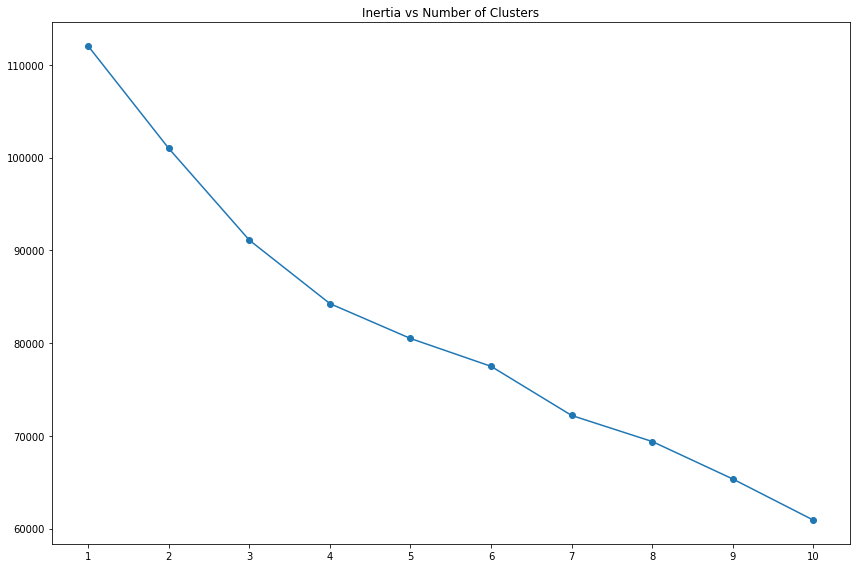

In [44]:
Y = pd.DataFrame(data_1_dummies_scaled)
inertias = []

for k in range(1, 11):
    model = KMeans(n_clusters=k)
    y = model.fit_predict(Y)
    inertias.append(model.inertia_)
    
plt.figure(figsize=(12, 8))
plt.plot(range(1, 11), inertias, marker='o')
plt.xticks(ticks=range(1, 11), labels=range(1, 11))
plt.title('Inertia vs Number of Clusters')

plt.tight_layout()
plt.show()

It looks like the rate of decreasing of the inertia slows down between 5 and 7 clusters. We'll use 5 clusters to move on.

In [45]:
model_1 = KMeans(n_clusters=5)
y_1 = model_1.fit_predict(data_1_dummies_scaled)

y_1

array([2, 2, 2, ..., 1, 1, 3], dtype=int32)

### 4.5 Analyzing data
After performing clustering over the subdataset, we will create a column named **CLUSTER** to label the cluster for each user.

In [46]:
data_1['CLUSTER'] = y_1 + 1
data_1.head()

,REGISTRATION_COUNTRY,PURCHASE_COUNT_DELIVERY,PURCHASE_COUNT_TAKEAWAY,BREAKFAST_PURCHASES,LUNCH_PURCHASES,EVENING_PURCHASES,DINNER_PURCHASES,TOTAL_PURCHASES_EUR,PREFERRED_DEVICE,IOS_PURCHASES,WEB_PURCHASES,ANDROID_PURCHASES,USER_HAS_VALID_PAYMENT_METHOD,MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE,MOST_COMMON_WEEKDAY_TO_PURCHASE,AVERAGE_DELIVERY_DISTANCE_KMS,REGISTRATION_RECENCY,REGISTRATION_TO_FIRST_PURCHASE,LAST_PURCHASE_RECENCY,CLUSTER
1,FIN,1.0,0.0,0.0,1.0,0.0,0.0,38.456,android,0.0,0.0,1.0,0,23,2,6.853,29,367,59,3
7,FIN,1.0,0.0,0.0,0.0,1.0,0.0,19.228,android,0.0,0.0,1.0,1,5,1,1.251,29,409,17,3
22,FIN,1.0,0.0,0.0,0.0,0.0,1.0,25.300,ios,1.0,0.0,0.0,1,7,5,9.408,29,419,7,3
24,FIN,1.0,0.0,0.0,0.0,1.0,0.0,14.168,ios,1.0,0.0,0.0,0,10,5,7.322,29,401,25,3
37,FIN,1.0,0.0,0.0,1.0,0.0,0.0,64.768,ios,1.0,0.0,0.0,1,6,5,7.431,29,412,14,3


In [47]:
data_1['CLUSTER'].value_counts()

1    1238
2    1040
4     839
3     726
5     306
Name: CLUSTER, dtype: int64

Next, we will plot the average value of each numeric variable per cluster.

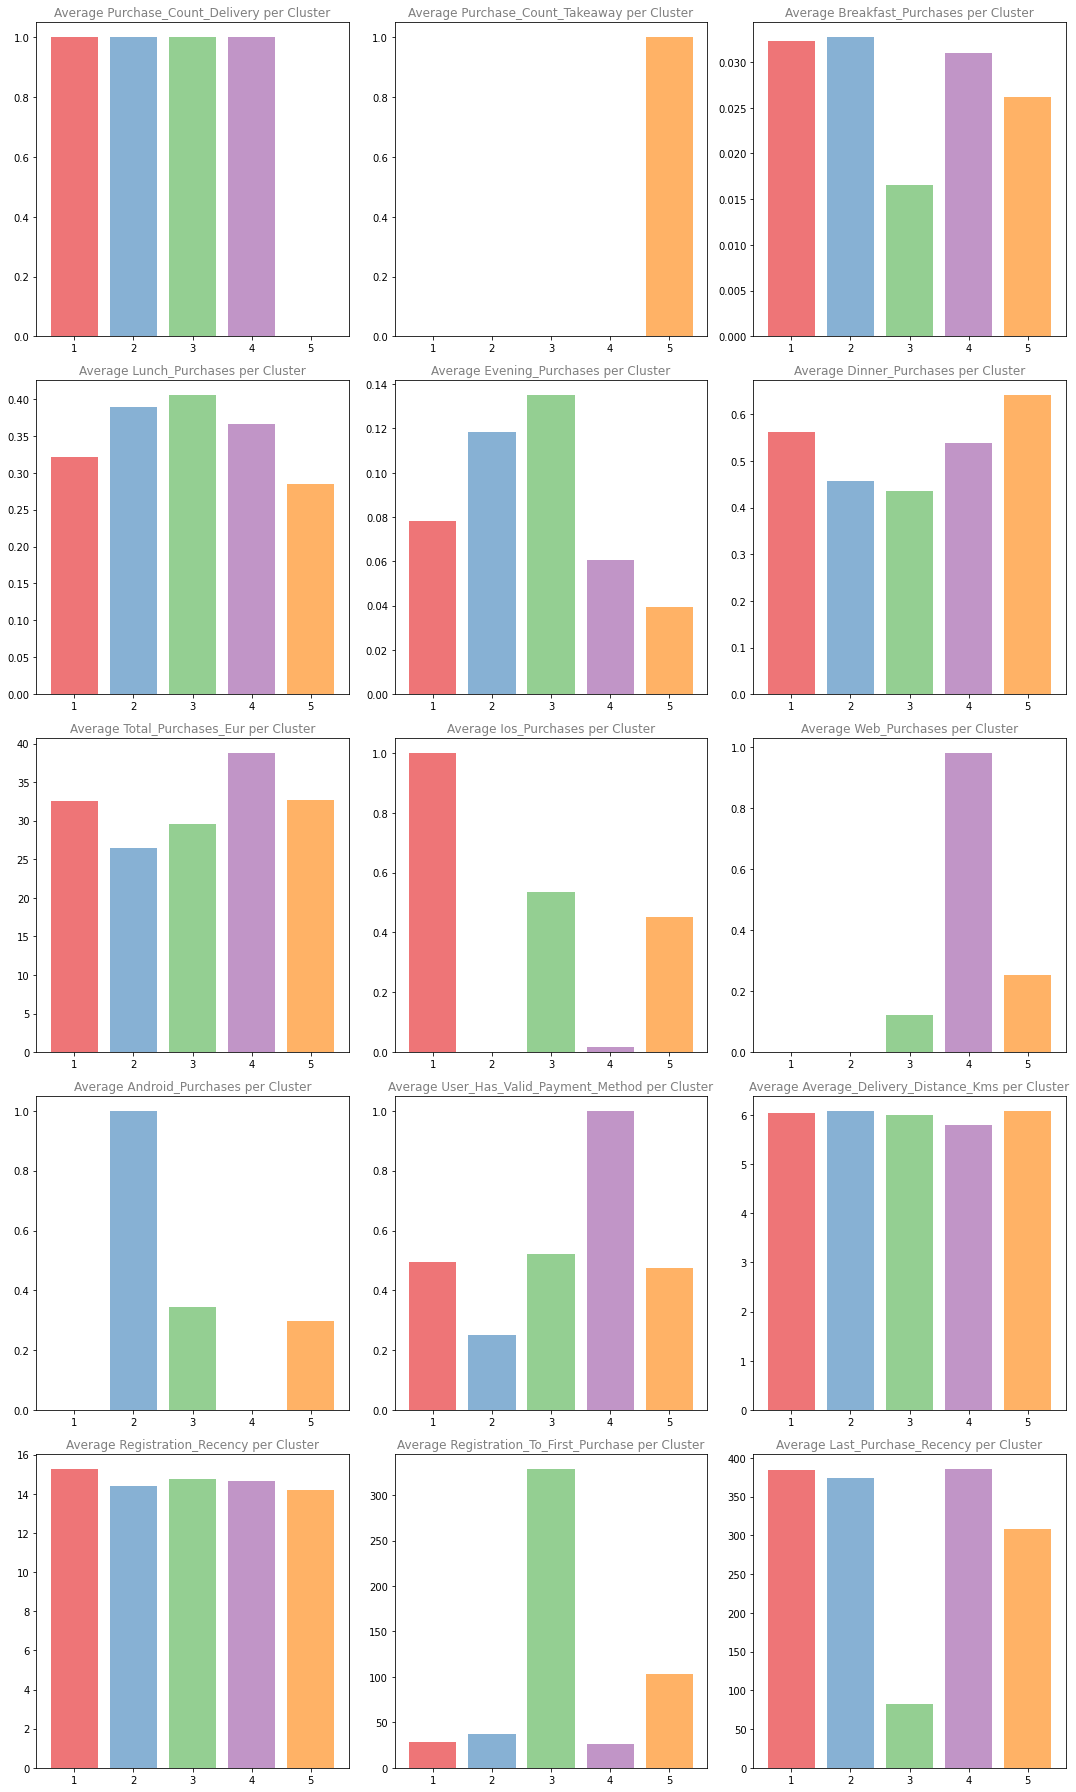

In [48]:
numeric_columns_1 = data_1.select_dtypes(include=np.number).drop(['CLUSTER'], axis=1).columns

fig = plt.figure(figsize=(15, 25))
for i, column in enumerate(numeric_columns_1):
    df_plot = data_1.groupby('CLUSTER')[column].mean()
    ax = fig.add_subplot(5, 3, i +1)

    ax.bar(df_plot.index, df_plot, color=sns.color_palette('Set1'), alpha=0.6)
    ax.set_title(f'Average {column.title()} per Cluster', alpha=0.5)
    ax.xaxis.grid(False)
    
plt.tight_layout()
plt.show()


For the categorical columns, we will plot the percentual distribution of each variable in each cluster. It is also worth noting that the chart will only display the legend of the top 3 registration countries for better visualization.

/var/folders/tl/svtqjw_s0kn4lpthrk3xjwpr0000gn/T/ipykernel_5877/2278877477.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(labels)
/var/folders/tl/svtqjw_s0kn4lpthrk3xjwpr0000gn/T/ipykernel_5877/2278877477.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(labels)


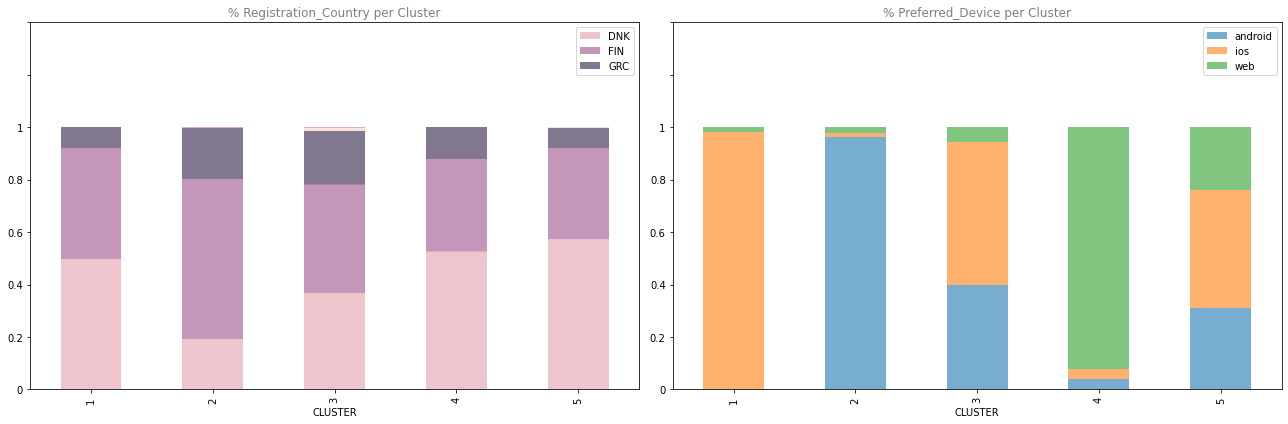

/var/folders/tl/svtqjw_s0kn4lpthrk3xjwpr0000gn/T/ipykernel_5877/2278877477.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels(labels)


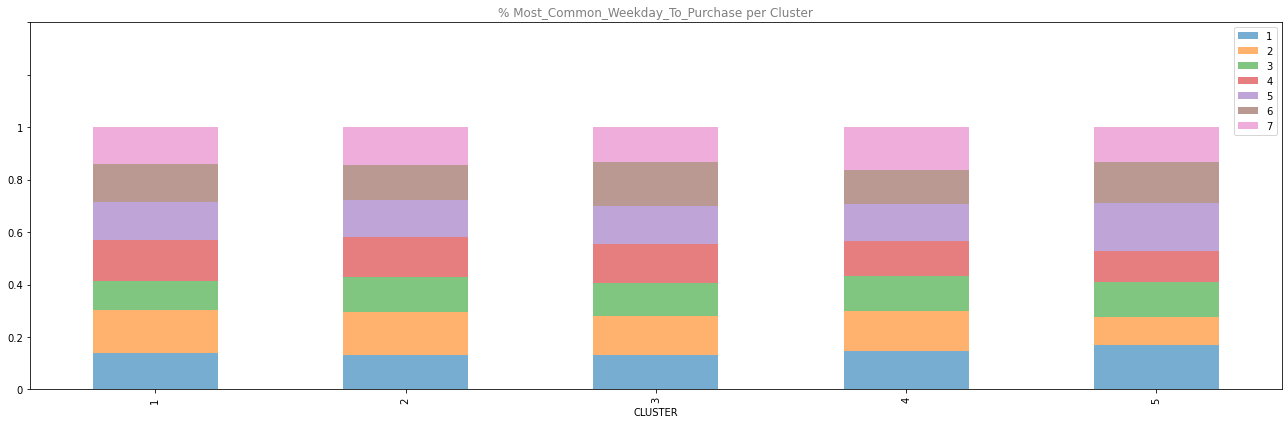

/var/folders/tl/svtqjw_s0kn4lpthrk3xjwpr0000gn/T/ipykernel_5877/2278877477.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_yticklabels(labels)


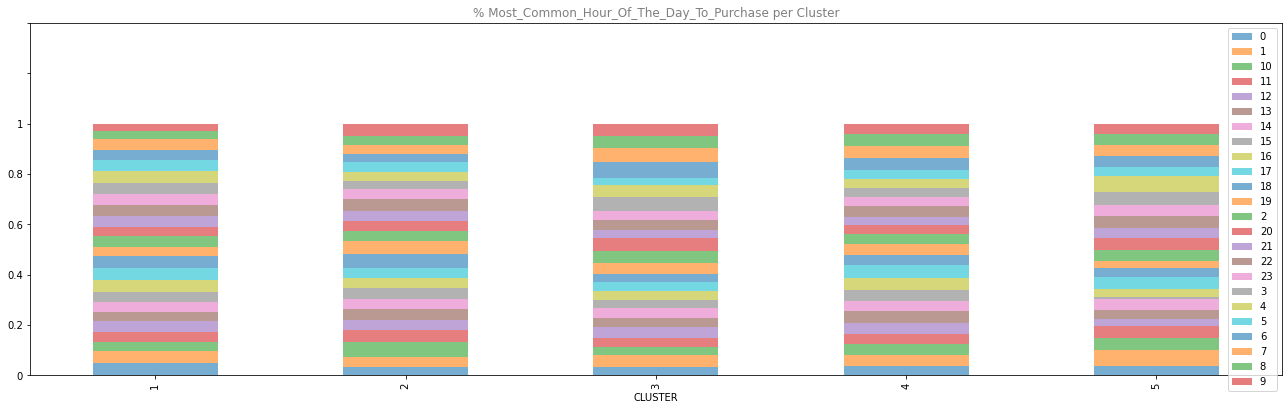

In [49]:
cat_column_3 = ['MOST_COMMON_WEEKDAY_TO_PURCHASE']

cat_column_4 = ['MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE']


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,
                                        figsize=(18,6))
for i, col in enumerate(cat_column_1):
    plot_df = pd.crosstab(index=data_1['CLUSTER'], columns=data_1[col], values=data_1[col], aggfunc='size', normalize='index')
    plot_df.plot.bar(stacked=True, ax=ax1, alpha=0.6, color=sns.cubehelix_palette(hue=1))
    ax1.set_title(f'% {col.title()} per Cluster', alpha=0.5)
    
    handle, label = ax1.get_legend_handles_labels()
    
    chosen_country = [1,3, 5]
    major_handle = [handle[t] for t in chosen_country]
    major_label = [label[t] for t in chosen_country]
    
    ax1.legend(major_handle, major_label)
 
    ax1.set_ylim(0, 1.4)
    ax1.xaxis.grid(False)
   
    labels = [0, 0.2, 0.4, 0.6, 0.8, 1]
    ax1.set_yticklabels(labels)
    
for i, col in enumerate(cat_column_2):
    plot_df = pd.crosstab(index=data_1['CLUSTER'], columns=data_1[col], values=data_1[col], aggfunc='size', normalize='index')
    plot_df.plot.bar(stacked=True, ax=ax2, alpha=0.6)
    ax2.set_title(f'% {col.title()} per Cluster', alpha=0.5)
    
    handle, label = ax2.get_legend_handles_labels()
    
   
    
    ax2.legend(handle, label)
 
    ax2.set_ylim(0, 1.4)
    ax2.xaxis.grid(False)
   
    labels = [0, 0.2, 0.4, 0.6, 0.8, 1]
    ax2.set_yticklabels(labels)

plt.tight_layout()
plt.show()
    

fig, (ax3) = plt.subplots(nrows=1, ncols=1,
                                        figsize=(18,6))    
for i, col in enumerate(cat_column_3):
    plot_df = pd.crosstab(index=data_1['CLUSTER'], columns=data_1[col], values=data_1[col], aggfunc='size', normalize='index')
    plot_df.plot.bar(stacked=True, ax=ax3, alpha=0.6)
    ax3.set_title(f'% {col.title()} per Cluster', alpha=0.5)
    
    handle, label = ax3.get_legend_handles_labels()
    
   
    
    ax3.legend(handle, label)
 
    ax3.set_ylim(0, 1.4)
    ax3.xaxis.grid(False)
   
    labels = [0, 0.2, 0.4, 0.6, 0.8, 1]
    ax3.set_yticklabels(labels)

plt.tight_layout()
plt.show()

 
fig, (ax4) = plt.subplots(nrows=1, ncols=1,
                                        figsize=(18,6))    
for i, col in enumerate(cat_column_4):
    plot_df = pd.crosstab(index=data_1['CLUSTER'], columns=data_1[col], values=data_1[col], aggfunc='size', normalize='index')
    plot_df.plot.bar(stacked=True, ax=ax4, alpha=0.6)
    ax4.set_title(f'% {col.title()} per Cluster', alpha=0.5)
    
    handle, label = ax4.get_legend_handles_labels()
    
    
    ax4.legend(handle, label)
 
    ax4.set_ylim(0, 1.4)
    ax4.xaxis.grid(False)
   
    labels = [0, 0.2, 0.4, 0.6, 0.8, 1]
    ax4.set_yticklabels(labels)

plt.tight_layout()
plt.show()


### 4.6 Description of user clusters considering purchase_count = 1
From the plots in this section, we are going to list the most important characteristics of each cluster of users given that these users made only one order (they were all restaurant orders) between September 2019 and October 2020.

**Cluster 1:** 
- Most of the users come from Denmark (50%), Finland (40%), and Greece (9%), prefer using ios devices (98%), and made purchases with this medium (100%). 
- About half of them have a valid payment method
- They only made delivery purchases (no takeaway at all)
- On average:
    + they spent about 33 euros per purchase
    + it took them about 25 days since registration to make the first and only purchase
    + the last and only purchase they made was about 380 days prior to the latest recorded purchase day
    

**Cluster 2:** 

- Most of the users come from Denmark (19%), Finland (60%), and Greece (19%), prefer using android (96%), and made purchases with this medium (100%)
- About a quarter of them have a valid payment method
- They only made delivery purchases (no takeaway at all)
- On average:
    + they spent about 27 euros per purchase
    + it took them about 30 days since registration to make the first and only purchase
    + the last and only purchase they made was about 375 days prior to the latest recorded purchase day

**Cluster 3:**
- Most of the users come from Denmark (35%), Finland (43%), and Greece (20%), prefer using ios (55%) and android (40%) devices, and made purchases with these media (90%). 
- About half of them have a valid payment method
- They only made delivery purchases (no takeaway at all)
- On average:
    + they spent about 30 euros per purchase
    + it took them about 330 days since registration to make the first and only purchase
    + the last and only purchase they made was about 80 days prior to the latest recorded purchase day




**Cluster 4:** 
- Most of the users come from Denmark (52%), Finland (38%), and Greece (9%), prefer using web (92%), and made purchases with this medium (98%). 
- All of them have a valid payment method
- They only made delivery purchases (no takeaway at all)
- On average:
    + they spent about 40 euros per purchase 
    + it took them about 25 days since registration to make the first and only purchase
    + the last and only purchase they made was about 380 days prior to the latest recorded purchase day



**Cluster 5:** 
- Most of the users come from Denmark (55%), Finland (38%), and Greece (6%), prefer using ios (50%) and android (30%) devices, and made purchases with these media (75%). 
- About half of them have a valid payment method
- They only made takeaway purchases (no delivery at all)
- On average:
    + they spent about 33 euros per purchase
    + it took them about 100 days since registration to make the first and only purchase
    + the last and only purchase they made was about 300 days prior to the latest recorded purchase day


## V. Examining users whose purchase_count > 1
In this section, we examine a subdatset of users whose purchase_count > 1. 

In [50]:
data_2 = data[(data["PURCHASE_COUNT"] > 1)]
data_2.head()

,REGISTRATION_DATE,REGISTRATION_COUNTRY,PURCHASE_COUNT,PURCHASE_COUNT_DELIVERY,PURCHASE_COUNT_TAKEAWAY,FIRST_PURCHASE_DAY,LAST_PURCHASE_DAY,USER_ID,BREAKFAST_PURCHASES,LUNCH_PURCHASES,...,WEB_PURCHASES,ANDROID_PURCHASES,PREFERRED_RESTAURANT_TYPES,USER_HAS_VALID_PAYMENT_METHOD,MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE,MOST_COMMON_WEEKDAY_TO_PURCHASE,AVG_DAYS_BETWEEN_PURCHASES,MEDIAN_DAYS_BETWEEN_PURCHASES,AVERAGE_DELIVERY_DISTANCE_KMS,PURCHASE_COUNT_BY_STORE_TYPE
2,2019-09-01,DNK,19,19.0,0.0,2019-12-10,2020-05-25,3,0.0,4.0,...,19.0,0.0,NaN,True,21,2,9.0,3.0,6.559,"{\n ""General merchandise"": 1,\n ""Grocery"": 9..."
12,2019-09-01,FIN,19,19.0,0.0,2020-04-18,2020-10-27,13,0.0,8.0,...,0.0,0.0,NaN,True,7,3,11.0,9.0,3.303,"{\n ""General merchandise"": 1,\n ""Grocery"": 9..."
13,2019-09-01,FIN,2,2.0,0.0,2020-08-21,2020-09-09,14,0.0,1.0,...,0.0,2.0,"[\n ""american""\n]",False,5,6,19.0,19.0,1.382,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
15,2019-09-01,FIN,2,2.0,0.0,2020-05-18,2020-07-06,16,0.0,2.0,...,0.0,0.0,NaN,False,0,1,49.0,49.0,4.619,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
16,2019-09-01,FIN,7,5.0,2.0,2019-12-05,2020-10-31,17,0.0,5.0,...,0.0,7.0,"[\n ""american""\n]",True,10,1,55.0,56.0,4.903,"{\n ""General merchandise"": 1,\n ""Grocery"": 3..."


In [51]:
data_2.isnull().sum()

REGISTRATION_DATE                             0
REGISTRATION_COUNTRY                          0
PURCHASE_COUNT                                0
PURCHASE_COUNT_DELIVERY                       0
PURCHASE_COUNT_TAKEAWAY                       0
FIRST_PURCHASE_DAY                           35
LAST_PURCHASE_DAY                             0
USER_ID                                       0
BREAKFAST_PURCHASES                           0
LUNCH_PURCHASES                               0
EVENING_PURCHASES                             0
DINNER_PURCHASES                              0
TOTAL_PURCHASES_EUR                           0
DISTINCT_PURCHASE_VENUE_COUNT                 0
MIN_PURCHASE_VALUE_EUR                        0
MAX_PURCHASE_VALUE_EUR                        0
AVG_PURCHASE_VALUE_EUR                        0
PREFERRED_DEVICE                              0
IOS_PURCHASES                                 0
WEB_PURCHASES                                 0
ANDROID_PURCHASES                       

In [52]:
data_2.nunique()

REGISTRATION_DATE                            30
REGISTRATION_COUNTRY                         19
PURCHASE_COUNT                              105
PURCHASE_COUNT_DELIVERY                     106
PURCHASE_COUNT_TAKEAWAY                      26
FIRST_PURCHASE_DAY                          413
LAST_PURCHASE_DAY                           427
USER_ID                                    7849
BREAKFAST_PURCHASES                          22
LUNCH_PURCHASES                              67
EVENING_PURCHASES                            31
DINNER_PURCHASES                             57
TOTAL_PURCHASES_EUR                        1082
DISTINCT_PURCHASE_VENUE_COUNT                40
MIN_PURCHASE_VALUE_EUR                       94
MAX_PURCHASE_VALUE_EUR                      209
AVG_PURCHASE_VALUE_EUR                      128
PREFERRED_DEVICE                              3
IOS_PURCHASES                                79
WEB_PURCHASES                                65
ANDROID_PURCHASES                       

We will remove the rows where the **FIRST_PURCHASE_DAY, AVG_DAYS_BETWEEN_PURCHASES**, or **MEDIAN_DAYS_BETWEEN_PURCHASES** value is null. Since there are only a few rows like this, the removal of these rows almost will not affect our data analysis.

In [53]:
index_row_to_drop = data_2[(data_2["FIRST_PURCHASE_DAY"].isna()) | (data_2["AVG_DAYS_BETWEEN_PURCHASES"].isna()) | 
                          (data_2["MEDIAN_DAYS_BETWEEN_PURCHASES"].isna()) ].index
data_2_filtered = data_2.drop(index_row_to_drop)

In [54]:
data_2_filtered.isnull().sum()

REGISTRATION_DATE                             0
REGISTRATION_COUNTRY                          0
PURCHASE_COUNT                                0
PURCHASE_COUNT_DELIVERY                       0
PURCHASE_COUNT_TAKEAWAY                       0
FIRST_PURCHASE_DAY                            0
LAST_PURCHASE_DAY                             0
USER_ID                                       0
BREAKFAST_PURCHASES                           0
LUNCH_PURCHASES                               0
EVENING_PURCHASES                             0
DINNER_PURCHASES                              0
TOTAL_PURCHASES_EUR                           0
DISTINCT_PURCHASE_VENUE_COUNT                 0
MIN_PURCHASE_VALUE_EUR                        0
MAX_PURCHASE_VALUE_EUR                        0
AVG_PURCHASE_VALUE_EUR                        0
PREFERRED_DEVICE                              0
IOS_PURCHASES                                 0
WEB_PURCHASES                                 0
ANDROID_PURCHASES                       

### 5.1 Transforming data
Now, we are going to parse the **PURCHASE_COUNT_BY_STORE_TYPE** column into multiple columns for the segmentation purpose.

In [55]:
parse_column = data_2_filtered['PURCHASE_COUNT_BY_STORE_TYPE'].apply(json.loads)
new_columns = pd.DataFrame(parse_column.tolist())
new_columns

,General merchandise,Grocery,Pet supplies,Restaurant,Retail store
0,1,9,0,9,0
1,1,9,0,9,0
2,0,0,0,2,0
3,0,0,0,2,0
4,1,3,0,3,0
...,...,...,...,...,...
7800,0,0,0,2,0
7801,0,0,0,3,3
7802,1,12,0,12,0
7803,0,0,0,4,0


In [56]:
data_2_filtered.reset_index(inplace = True)

Next, we are about to merge the columns that we have just parsed from the **PURCHASE_COUNT_BY_STORE_TYPE** column with the subdataset in this section.

In [57]:
data_2_filtered_added = pd.concat([data_2_filtered, new_columns], axis=1)
data_2_filtered_added

,index,REGISTRATION_DATE,REGISTRATION_COUNTRY,PURCHASE_COUNT,PURCHASE_COUNT_DELIVERY,PURCHASE_COUNT_TAKEAWAY,FIRST_PURCHASE_DAY,LAST_PURCHASE_DAY,USER_ID,BREAKFAST_PURCHASES,...,MOST_COMMON_WEEKDAY_TO_PURCHASE,AVG_DAYS_BETWEEN_PURCHASES,MEDIAN_DAYS_BETWEEN_PURCHASES,AVERAGE_DELIVERY_DISTANCE_KMS,PURCHASE_COUNT_BY_STORE_TYPE,General merchandise,Grocery,Pet supplies,Restaurant,Retail store
0,2,2019-09-01,DNK,19,19.0,0.0,2019-12-10,2020-05-25,3,0.0,...,2,9.0,3.0,6.559,"{\n ""General merchandise"": 1,\n ""Grocery"": 9...",1,9,0,9,0
1,12,2019-09-01,FIN,19,19.0,0.0,2020-04-18,2020-10-27,13,0.0,...,3,11.0,9.0,3.303,"{\n ""General merchandise"": 1,\n ""Grocery"": 9...",1,9,0,9,0
2,13,2019-09-01,FIN,2,2.0,0.0,2020-08-21,2020-09-09,14,0.0,...,6,19.0,19.0,1.382,"{\n ""General merchandise"": 0,\n ""Grocery"": 0...",0,0,0,2,0
3,15,2019-09-01,FIN,2,2.0,0.0,2020-05-18,2020-07-06,16,0.0,...,1,49.0,49.0,4.619,"{\n ""General merchandise"": 0,\n ""Grocery"": 0...",0,0,0,2,0
4,16,2019-09-01,FIN,7,5.0,2.0,2019-12-05,2020-10-31,17,0.0,...,1,55.0,56.0,4.903,"{\n ""General merchandise"": 1,\n ""Grocery"": 3...",1,3,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7800,21966,2019-09-30,DNK,2,2.0,0.0,2020-07-17,2020-08-03,21967,0.0,...,7,17.0,17.0,2.281,"{\n ""General merchandise"": 0,\n ""Grocery"": 0...",0,0,0,2,0
7801,21969,2019-09-30,FIN,6,6.0,0.0,2019-10-07,2020-06-02,21970,0.0,...,7,48.0,1.0,3.320,"{\n ""General merchandise"": 0,\n ""Grocery"": 0...",0,0,0,3,3
7802,21971,2019-09-30,GRC,25,25.0,0.0,2019-10-06,2020-10-22,21972,0.0,...,5,16.0,9.0,2.753,"{\n ""General merchandise"": 1,\n ""Grocery"": 1...",1,12,0,12,0
7803,21972,2019-09-30,FIN,4,4.0,0.0,2020-03-07,2020-06-11,21973,1.0,...,2,32.0,7.0,7.637,"{\n ""General merchandise"": 0,\n ""Grocery"": 0...",0,0,0,4,0


Next, we will create the following columns for the segmentation purpose:

**1. REGISTRATION_RECENCY:** describing how recently a customer has registered since the latest recorded registration date. Values in this column result from the latest **REGISTRATION_DATE** minus the corresponding **REGISTRATION_DATE** in each row.

**2. REGISTRATION_TO_FIRST_PURCHASE:** describing how fast a customer has made the first purchase since registration.  Values in this column result from the corresponding **FIRST_PURCHASE_DAY** minus the corresponding **REGISTRATION_DATE** in each row.

**3. LAST_PURCHASE_RECENCY:** describing how recently a customer has made the last purchase since the latest recorded purchase. Values in this column result from the latest **LAST_PURCHASE_DAY** minus the corresponding **LAST_PURCHASE_DAY** in each row.

We also will delete the **'REGISTRATION_DATE','FIRST_PURCHASE_DAY','LAST_PURCHASE_DAY'** columns after that for the segmentation purpose (they are not numeric).

In [58]:
data_2_filtered_added["REGISTRATION_RECENCY"] = (max(data_2_filtered_added["REGISTRATION_DATE"]) - data_2_filtered_added["REGISTRATION_DATE"]).dt.days
data_2_filtered_added["REGISTRATION_TO_FIRST_PURCHASE"] = (data_2_filtered_added["FIRST_PURCHASE_DAY"] - data_2_filtered_added["REGISTRATION_DATE"]).dt.days
data_2_filtered_added["LAST_PURCHASE_RECENCY"] = (max(data_2_filtered_added["LAST_PURCHASE_DAY"]) - data_2_filtered_added["LAST_PURCHASE_DAY"]).dt.days
data_2_filtered_added.head()

,index,REGISTRATION_DATE,REGISTRATION_COUNTRY,PURCHASE_COUNT,PURCHASE_COUNT_DELIVERY,PURCHASE_COUNT_TAKEAWAY,FIRST_PURCHASE_DAY,LAST_PURCHASE_DAY,USER_ID,BREAKFAST_PURCHASES,...,AVERAGE_DELIVERY_DISTANCE_KMS,PURCHASE_COUNT_BY_STORE_TYPE,General merchandise,Grocery,Pet supplies,Restaurant,Retail store,REGISTRATION_RECENCY,REGISTRATION_TO_FIRST_PURCHASE,LAST_PURCHASE_RECENCY
0,2,2019-09-01,DNK,19,19.0,0.0,2019-12-10,2020-05-25,3,0.0,...,6.559,"{\n ""General merchandise"": 1,\n ""Grocery"": 9...",1,9,0,9,0,29,100,159
1,12,2019-09-01,FIN,19,19.0,0.0,2020-04-18,2020-10-27,13,0.0,...,3.303,"{\n ""General merchandise"": 1,\n ""Grocery"": 9...",1,9,0,9,0,29,230,4
2,13,2019-09-01,FIN,2,2.0,0.0,2020-08-21,2020-09-09,14,0.0,...,1.382,"{\n ""General merchandise"": 0,\n ""Grocery"": 0...",0,0,0,2,0,29,355,52
3,15,2019-09-01,FIN,2,2.0,0.0,2020-05-18,2020-07-06,16,0.0,...,4.619,"{\n ""General merchandise"": 0,\n ""Grocery"": 0...",0,0,0,2,0,29,260,117
4,16,2019-09-01,FIN,7,5.0,2.0,2019-12-05,2020-10-31,17,0.0,...,4.903,"{\n ""General merchandise"": 1,\n ""Grocery"": 3...",1,3,0,3,0,29,95,0


In [59]:
data_2_filtered_added.isnull().sum()

index                                         0
REGISTRATION_DATE                             0
REGISTRATION_COUNTRY                          0
PURCHASE_COUNT                                0
PURCHASE_COUNT_DELIVERY                       0
PURCHASE_COUNT_TAKEAWAY                       0
FIRST_PURCHASE_DAY                            0
LAST_PURCHASE_DAY                             0
USER_ID                                       0
BREAKFAST_PURCHASES                           0
LUNCH_PURCHASES                               0
EVENING_PURCHASES                             0
DINNER_PURCHASES                              0
TOTAL_PURCHASES_EUR                           0
DISTINCT_PURCHASE_VENUE_COUNT                 0
MIN_PURCHASE_VALUE_EUR                        0
MAX_PURCHASE_VALUE_EUR                        0
AVG_PURCHASE_VALUE_EUR                        0
PREFERRED_DEVICE                              0
IOS_PURCHASES                                 0
WEB_PURCHASES                           

Now, we will divide the subdataset into two smaller ones: one with null values and one without null values.

In [60]:
data_2_filtered_added_no_null = data_2_filtered_added[~data_2_filtered_added["PREFERRED_RESTAURANT_TYPES"].isnull()]


In [61]:
data_2_filtered_added_null = data_2_filtered_added[data_2_filtered_added["PREFERRED_RESTAURANT_TYPES"].isnull()]

In [62]:
len(data_2_filtered_added_null)

5358

Then, we will transform the **PREFERRED_RESTAURANT_TYPES** column in the subdataset without null values into lists.

In [63]:
restaurant = data_2_filtered_added_no_null["PREFERRED_RESTAURANT_TYPES"].apply(eval)

In [64]:
restaurant.tail()

7788              [mexican]
7789             [american]
7791              [chinese]
7796              [italian]
7801    [american, italian]
Name: PREFERRED_RESTAURANT_TYPES, dtype: object

Now, we are going to dummy-code the **restaurant** series since it is non-numerical.


In [65]:
restaurant_dummies = restaurant.str.join('|').str.get_dummies()
restaurant_dummies 

,american,chinese,greek,hawaiian,indian,italian,japanese,korean,mexican,middle eastern,nepalese,spanish,thai,vietnamese
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0,0,0,0,0
8,0,0,0,0,0,1,0,0,0,0,0,0,0,0
10,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7788,0,0,0,0,0,0,0,0,1,0,0,0,0,0
7789,1,0,0,0,0,0,0,0,0,0,0,0,0,0
7791,0,1,0,0,0,0,0,0,0,0,0,0,0,0
7796,0,0,0,0,0,1,0,0,0,0,0,0,0,0


Next, we will merge the columns we have just dummy-coded with the subdataset without null values and then create a column named **restaurant_null**. We will fill in this column with 0 since all the users in the subdataset without null values reported having at least one preferred restaurant type.

In [66]:
data_2_filtered_added_no_null_dummies = pd.concat([data_2_filtered_added_no_null, restaurant_dummies], axis=1)
data_2_filtered_added_no_null_dummies["restaurant_null"] = 0
data_2_filtered_added_no_null_dummies

,index,REGISTRATION_DATE,REGISTRATION_COUNTRY,PURCHASE_COUNT,PURCHASE_COUNT_DELIVERY,PURCHASE_COUNT_TAKEAWAY,FIRST_PURCHASE_DAY,LAST_PURCHASE_DAY,USER_ID,BREAKFAST_PURCHASES,...,italian,japanese,korean,mexican,middle eastern,nepalese,spanish,thai,vietnamese,restaurant_null
2,13,2019-09-01,FIN,2,2.0,0.0,2020-08-21,2020-09-09,14,0.0,...,0,0,0,0,0,0,0,0,0,0
4,16,2019-09-01,FIN,7,5.0,2.0,2019-12-05,2020-10-31,17,0.0,...,0,0,0,0,0,0,0,0,0,0
5,17,2019-09-01,DNK,2,2.0,0.0,2019-09-05,2020-05-16,18,0.0,...,0,1,0,0,0,0,0,0,0,0
8,26,2019-09-01,FIN,6,6.0,0.0,2020-02-02,2020-10-18,27,0.0,...,1,0,0,0,0,0,0,0,0,0
10,31,2019-09-01,LVA,33,32.0,1.0,2019-09-13,2020-10-29,32,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7788,21921,2019-09-30,DNK,2,2.0,0.0,2019-09-30,2019-10-01,21922,0.0,...,0,0,0,1,0,0,0,0,0,0
7789,21923,2019-09-30,FIN,3,3.0,0.0,2019-10-30,2020-05-08,21924,1.0,...,0,0,0,0,0,0,0,0,0,0
7791,21929,2019-09-30,DNK,25,25.0,0.0,2019-10-07,2020-10-18,21930,0.0,...,0,0,0,0,0,0,0,0,0,0
7796,21947,2019-09-30,DNK,2,2.0,0.0,2020-02-09,2020-10-18,21948,0.0,...,1,0,0,0,0,0,0,0,0,0


In [67]:
list(restaurant_dummies.columns)

['american',
 'chinese',
 'greek',
 'hawaiian',
 'indian',
 'italian',
 'japanese',
 'korean',
 'mexican',
 'middle eastern',
 'nepalese',
 'spanish',
 'thai',
 'vietnamese']

Now, we are going to create a dataframe whose columns are named after those in the **restaurant_dummies** dataframe. We will fill in these columns with 0 and then merge them with the subdataset with null values since all the users in this subdataset reported having no preferred restaurant type. After that, we will create a column named **restaurant_null** and fill in this column = 1 for the same reason.

In [68]:
restaurant_dummies_1 = pd.DataFrame(0, index=data_2_filtered_added_null.index, columns=list(restaurant_dummies.columns))
restaurant_dummies_1

,american,chinese,greek,hawaiian,indian,italian,japanese,korean,mexican,middle eastern,nepalese,spanish,thai,vietnamese
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7799,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7800,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7802,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7803,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [69]:
data_2_filtered_added_null_dummies = pd.concat([data_2_filtered_added_null, restaurant_dummies_1], axis=1)
data_2_filtered_added_null_dummies["restaurant_null"] = 1
data_2_filtered_added_null_dummies

,index,REGISTRATION_DATE,REGISTRATION_COUNTRY,PURCHASE_COUNT,PURCHASE_COUNT_DELIVERY,PURCHASE_COUNT_TAKEAWAY,FIRST_PURCHASE_DAY,LAST_PURCHASE_DAY,USER_ID,BREAKFAST_PURCHASES,...,italian,japanese,korean,mexican,middle eastern,nepalese,spanish,thai,vietnamese,restaurant_null
0,2,2019-09-01,DNK,19,19.0,0.0,2019-12-10,2020-05-25,3,0.0,...,0,0,0,0,0,0,0,0,0,1
1,12,2019-09-01,FIN,19,19.0,0.0,2020-04-18,2020-10-27,13,0.0,...,0,0,0,0,0,0,0,0,0,1
3,15,2019-09-01,FIN,2,2.0,0.0,2020-05-18,2020-07-06,16,0.0,...,0,0,0,0,0,0,0,0,0,1
6,20,2019-09-01,GRC,3,3.0,0.0,2020-04-26,2020-05-28,21,0.0,...,0,0,0,0,0,0,0,0,0,1
7,21,2019-09-01,FIN,4,4.0,0.0,2019-10-27,2020-07-08,22,0.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7799,21964,2019-09-30,GRC,25,25.0,0.0,2019-10-09,2020-10-14,21965,7.0,...,0,0,0,0,0,0,0,0,0,1
7800,21966,2019-09-30,DNK,2,2.0,0.0,2020-07-17,2020-08-03,21967,0.0,...,0,0,0,0,0,0,0,0,0,1
7802,21971,2019-09-30,GRC,25,25.0,0.0,2019-10-06,2020-10-22,21972,0.0,...,0,0,0,0,0,0,0,0,0,1
7803,21972,2019-09-30,FIN,4,4.0,0.0,2020-03-07,2020-06-11,21973,1.0,...,0,0,0,0,0,0,0,0,0,1


Next, we will merge the subdataset with null values and the one without null values.

In [70]:
data_2_merged = pd.concat([data_2_filtered_added_null_dummies, data_2_filtered_added_no_null_dummies], axis=0)
data_2_merged

,index,REGISTRATION_DATE,REGISTRATION_COUNTRY,PURCHASE_COUNT,PURCHASE_COUNT_DELIVERY,PURCHASE_COUNT_TAKEAWAY,FIRST_PURCHASE_DAY,LAST_PURCHASE_DAY,USER_ID,BREAKFAST_PURCHASES,...,italian,japanese,korean,mexican,middle eastern,nepalese,spanish,thai,vietnamese,restaurant_null
0,2,2019-09-01,DNK,19,19.0,0.0,2019-12-10,2020-05-25,3,0.0,...,0,0,0,0,0,0,0,0,0,1
1,12,2019-09-01,FIN,19,19.0,0.0,2020-04-18,2020-10-27,13,0.0,...,0,0,0,0,0,0,0,0,0,1
3,15,2019-09-01,FIN,2,2.0,0.0,2020-05-18,2020-07-06,16,0.0,...,0,0,0,0,0,0,0,0,0,1
6,20,2019-09-01,GRC,3,3.0,0.0,2020-04-26,2020-05-28,21,0.0,...,0,0,0,0,0,0,0,0,0,1
7,21,2019-09-01,FIN,4,4.0,0.0,2019-10-27,2020-07-08,22,0.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7788,21921,2019-09-30,DNK,2,2.0,0.0,2019-09-30,2019-10-01,21922,0.0,...,0,0,0,1,0,0,0,0,0,0
7789,21923,2019-09-30,FIN,3,3.0,0.0,2019-10-30,2020-05-08,21924,1.0,...,0,0,0,0,0,0,0,0,0,0
7791,21929,2019-09-30,DNK,25,25.0,0.0,2019-10-07,2020-10-18,21930,0.0,...,0,0,0,0,0,0,0,0,0,0
7796,21947,2019-09-30,DNK,2,2.0,0.0,2020-02-09,2020-10-18,21948,0.0,...,1,0,0,0,0,0,0,0,0,0


In [71]:
data_2_merged.isnull().sum()

index                                         0
REGISTRATION_DATE                             0
REGISTRATION_COUNTRY                          0
PURCHASE_COUNT                                0
PURCHASE_COUNT_DELIVERY                       0
PURCHASE_COUNT_TAKEAWAY                       0
FIRST_PURCHASE_DAY                            0
LAST_PURCHASE_DAY                             0
USER_ID                                       0
BREAKFAST_PURCHASES                           0
LUNCH_PURCHASES                               0
EVENING_PURCHASES                             0
DINNER_PURCHASES                              0
TOTAL_PURCHASES_EUR                           0
DISTINCT_PURCHASE_VENUE_COUNT                 0
MIN_PURCHASE_VALUE_EUR                        0
MAX_PURCHASE_VALUE_EUR                        0
AVG_PURCHASE_VALUE_EUR                        0
PREFERRED_DEVICE                              0
IOS_PURCHASES                                 0
WEB_PURCHASES                           

In [72]:
data_2_merged.nunique()

index                                      7805
REGISTRATION_DATE                            30
REGISTRATION_COUNTRY                         19
PURCHASE_COUNT                              105
PURCHASE_COUNT_DELIVERY                     106
PURCHASE_COUNT_TAKEAWAY                      26
FIRST_PURCHASE_DAY                          413
LAST_PURCHASE_DAY                           427
USER_ID                                    7805
BREAKFAST_PURCHASES                          22
LUNCH_PURCHASES                              67
EVENING_PURCHASES                            31
DINNER_PURCHASES                             57
TOTAL_PURCHASES_EUR                        1081
DISTINCT_PURCHASE_VENUE_COUNT                40
MIN_PURCHASE_VALUE_EUR                       94
MAX_PURCHASE_VALUE_EUR                      209
AVG_PURCHASE_VALUE_EUR                      128
PREFERRED_DEVICE                              3
IOS_PURCHASES                                79
WEB_PURCHASES                           

Now, we are going to dummy-code the **REGISTRATION_COUNTRY** and **PREFERRED_DEVICE** columns including null values in the **PREFERRED_DEVICE** column since these columns are non-numerical.

Then, we will replace True and False values in the **USER_HAS_VALID_PAYMENT_METHOD** column with 1 and 0 respectively for the segmentation purpose.

We also will delete the **"PREFERRED_RESTAURANT_TYPES", "index", 'REGISTRATION_DATE',
                     "FIRST_PURCHASE_DAY", "LAST_PURCHASE_DAY",
                     'REGISTRATION_COUNTRY','PREFERRED_DEVICE',
                    "PURCHASE_COUNT_BY_STORE_TYPE",
                    "USER_ID"** columns after that for the segmentation purpose.

In [73]:
dummies_5 = pd.get_dummies(data_2_merged[['REGISTRATION_COUNTRY']], drop_first=True)
dummies_6 = pd.get_dummies(data_2_merged[['PREFERRED_DEVICE']], drop_first=True, dummy_na = True)

data_2_merged_dummies = pd.concat([data_2_merged, dummies_5, dummies_6], axis=1)
data_2_merged_dummies.head()

,index,REGISTRATION_DATE,REGISTRATION_COUNTRY,PURCHASE_COUNT,PURCHASE_COUNT_DELIVERY,PURCHASE_COUNT_TAKEAWAY,FIRST_PURCHASE_DAY,LAST_PURCHASE_DAY,USER_ID,BREAKFAST_PURCHASES,...,REGISTRATION_COUNTRY_HUN,REGISTRATION_COUNTRY_ISR,REGISTRATION_COUNTRY_LTU,REGISTRATION_COUNTRY_LVA,REGISTRATION_COUNTRY_NOR,REGISTRATION_COUNTRY_POL,REGISTRATION_COUNTRY_SWE,PREFERRED_DEVICE_ios,PREFERRED_DEVICE_web,PREFERRED_DEVICE_nan
0,2,2019-09-01,DNK,19,19.0,0.0,2019-12-10,2020-05-25,3,0.0,...,0,0,0,0,0,0,0,0,0,0
1,12,2019-09-01,FIN,19,19.0,0.0,2020-04-18,2020-10-27,13,0.0,...,0,0,0,0,0,0,0,1,0,0
3,15,2019-09-01,FIN,2,2.0,0.0,2020-05-18,2020-07-06,16,0.0,...,0,0,0,0,0,0,0,1,0,0
6,20,2019-09-01,GRC,3,3.0,0.0,2020-04-26,2020-05-28,21,0.0,...,0,0,0,0,0,0,0,1,0,0
7,21,2019-09-01,FIN,4,4.0,0.0,2019-10-27,2020-07-08,22,0.0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
data_2_merged_dummies.replace({False:0, True:1}, inplace = True)


In [75]:
columns_to_drop_3 = ["PREFERRED_RESTAURANT_TYPES", "index", 'REGISTRATION_DATE',
                     "FIRST_PURCHASE_DAY", "LAST_PURCHASE_DAY",
                     'REGISTRATION_COUNTRY','PREFERRED_DEVICE',
                    "PURCHASE_COUNT_BY_STORE_TYPE",
                    "USER_ID"]

In [76]:
data_2_merged_dummies.drop(columns_to_drop_3, axis=1, inplace=True)


### 5.2 Scaling data
After making the whole subdataset numerical, we will standardize it.



In [77]:
scaler.fit(data_2_merged_dummies)

data_2_merged_dummies_scaled = scaler.transform(data_2_merged_dummies)

### 5.3 Choosing K
Now, we are going to run the k-means algorithm considering a range from 1 to 10 and plot the elbow curve to find the optimal the number of clusters K.


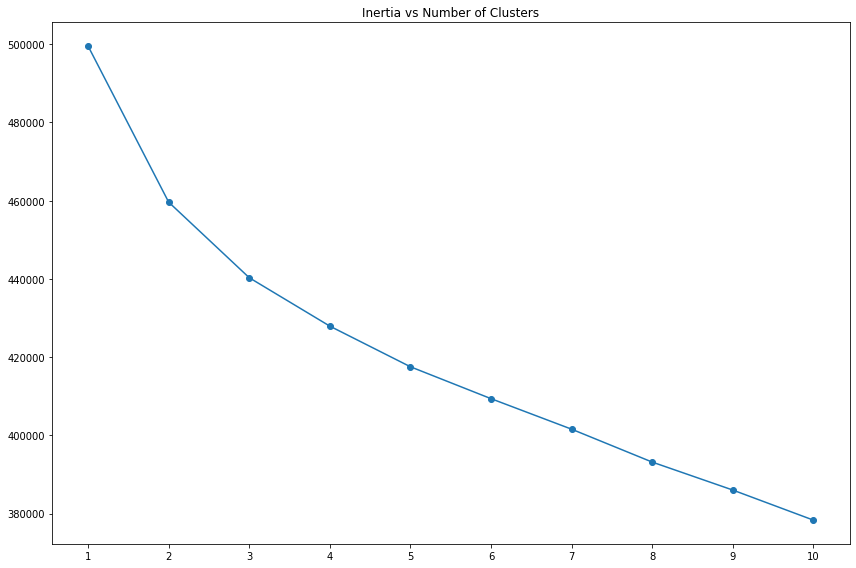

In [78]:

Z = pd.DataFrame(data_2_merged_dummies_scaled)
inertias = []

for k in range(1, 11):
    model = KMeans(n_clusters=k)
    y = model.fit_predict(Z)
    inertias.append(model.inertia_)
    
plt.figure(figsize=(12, 8))
plt.plot(range(1, 11), inertias, marker='o')
plt.xticks(ticks=range(1, 11), labels=range(1, 11))
plt.title('Inertia vs Number of Clusters')

plt.tight_layout()
plt.show()

It looks like the rate of decreasing of the inertia slows down between 5 and 7 clusters. We'll use 5 clusters to move on.

In [79]:
model_2 = KMeans(n_clusters=5)
y_2 = model_2.fit_predict(data_2_merged_dummies_scaled)

y_2

array([3, 3, 1, ..., 3, 4, 1], dtype=int32)

### 5.4 Analyzing data
After performing clustering over the subdataset, we will create a column named **CLUSTER** to label the cluster for each user.

In [80]:
data_2_merged['CLUSTER'] = y_2 + 1
data_2_merged.head()

,index,REGISTRATION_DATE,REGISTRATION_COUNTRY,PURCHASE_COUNT,PURCHASE_COUNT_DELIVERY,PURCHASE_COUNT_TAKEAWAY,FIRST_PURCHASE_DAY,LAST_PURCHASE_DAY,USER_ID,BREAKFAST_PURCHASES,...,japanese,korean,mexican,middle eastern,nepalese,spanish,thai,vietnamese,restaurant_null,CLUSTER
0,2,2019-09-01,DNK,19,19.0,0.0,2019-12-10,2020-05-25,3,0.0,...,0,0,0,0,0,0,0,0,1,4
1,12,2019-09-01,FIN,19,19.0,0.0,2020-04-18,2020-10-27,13,0.0,...,0,0,0,0,0,0,0,0,1,4
3,15,2019-09-01,FIN,2,2.0,0.0,2020-05-18,2020-07-06,16,0.0,...,0,0,0,0,0,0,0,0,1,2
6,20,2019-09-01,GRC,3,3.0,0.0,2020-04-26,2020-05-28,21,0.0,...,0,0,0,0,0,0,0,0,1,1
7,21,2019-09-01,FIN,4,4.0,0.0,2019-10-27,2020-07-08,22,0.0,...,0,0,0,0,0,0,0,0,1,2


In [81]:
columns_to_drop_4 = ["PREFERRED_RESTAURANT_TYPES", "index", 'REGISTRATION_DATE',
                     "FIRST_PURCHASE_DAY", "LAST_PURCHASE_DAY",
                    "PURCHASE_COUNT_BY_STORE_TYPE",
                    "USER_ID"]

In [82]:
data_2_merged.replace({False:0, True:1}, inplace = True)


In [83]:
data_2_merged.drop(columns_to_drop_4, axis=1, inplace=True)
data_2_merged.head()

,REGISTRATION_COUNTRY,PURCHASE_COUNT,PURCHASE_COUNT_DELIVERY,PURCHASE_COUNT_TAKEAWAY,BREAKFAST_PURCHASES,LUNCH_PURCHASES,EVENING_PURCHASES,DINNER_PURCHASES,TOTAL_PURCHASES_EUR,DISTINCT_PURCHASE_VENUE_COUNT,...,japanese,korean,mexican,middle eastern,nepalese,spanish,thai,vietnamese,restaurant_null,CLUSTER
0,DNK,19,19.0,0.0,0.0,4.0,1.0,14.0,631.488,9.0,...,0,0,0,0,0,0,0,0,1,4
1,FIN,19,19.0,0.0,0.0,8.0,0.0,11.0,587.972,3.0,...,0,0,0,0,0,0,0,0,1,4
3,FIN,2,2.0,0.0,0.0,2.0,0.0,0.0,107.272,1.0,...,0,0,0,0,0,0,0,0,1,2
6,GRC,3,3.0,0.0,0.0,1.0,0.0,2.0,25.300,3.0,...,0,0,0,0,0,0,0,0,1,1
7,FIN,4,4.0,0.0,0.0,0.0,0.0,4.0,109.296,4.0,...,0,0,0,0,0,0,0,0,1,2


In [84]:
data_2_merged["CLUSTER"].value_counts()

2    2703
5    2549
4    1416
1     887
3     250
Name: CLUSTER, dtype: int64

In [85]:
data_2_merged.groupby("CLUSTER")["REGISTRATION_COUNTRY"].value_counts(ascending = False)

CLUSTER  REGISTRATION_COUNTRY
1        GRC                      887
2        FIN                     2670
         EST                        6
         NOR                        6
         HUN                        5
         CZE                        2
         POL                        2
         ARE                        1
         CAN                        1
         CYP                        1
         DEU                        1
         DNK                        1
         FRA                        1
         GBR                        1
         HRV                        1
         ISR                        1
         LTU                        1
         LVA                        1
         SWE                        1
3        FIN                      117
         DNK                       90
         GRC                       41
         CZE                        1
         LVA                        1
4        FIN                      764
         DNK        

Next, we will plot the average value of each numeric variable per cluster.

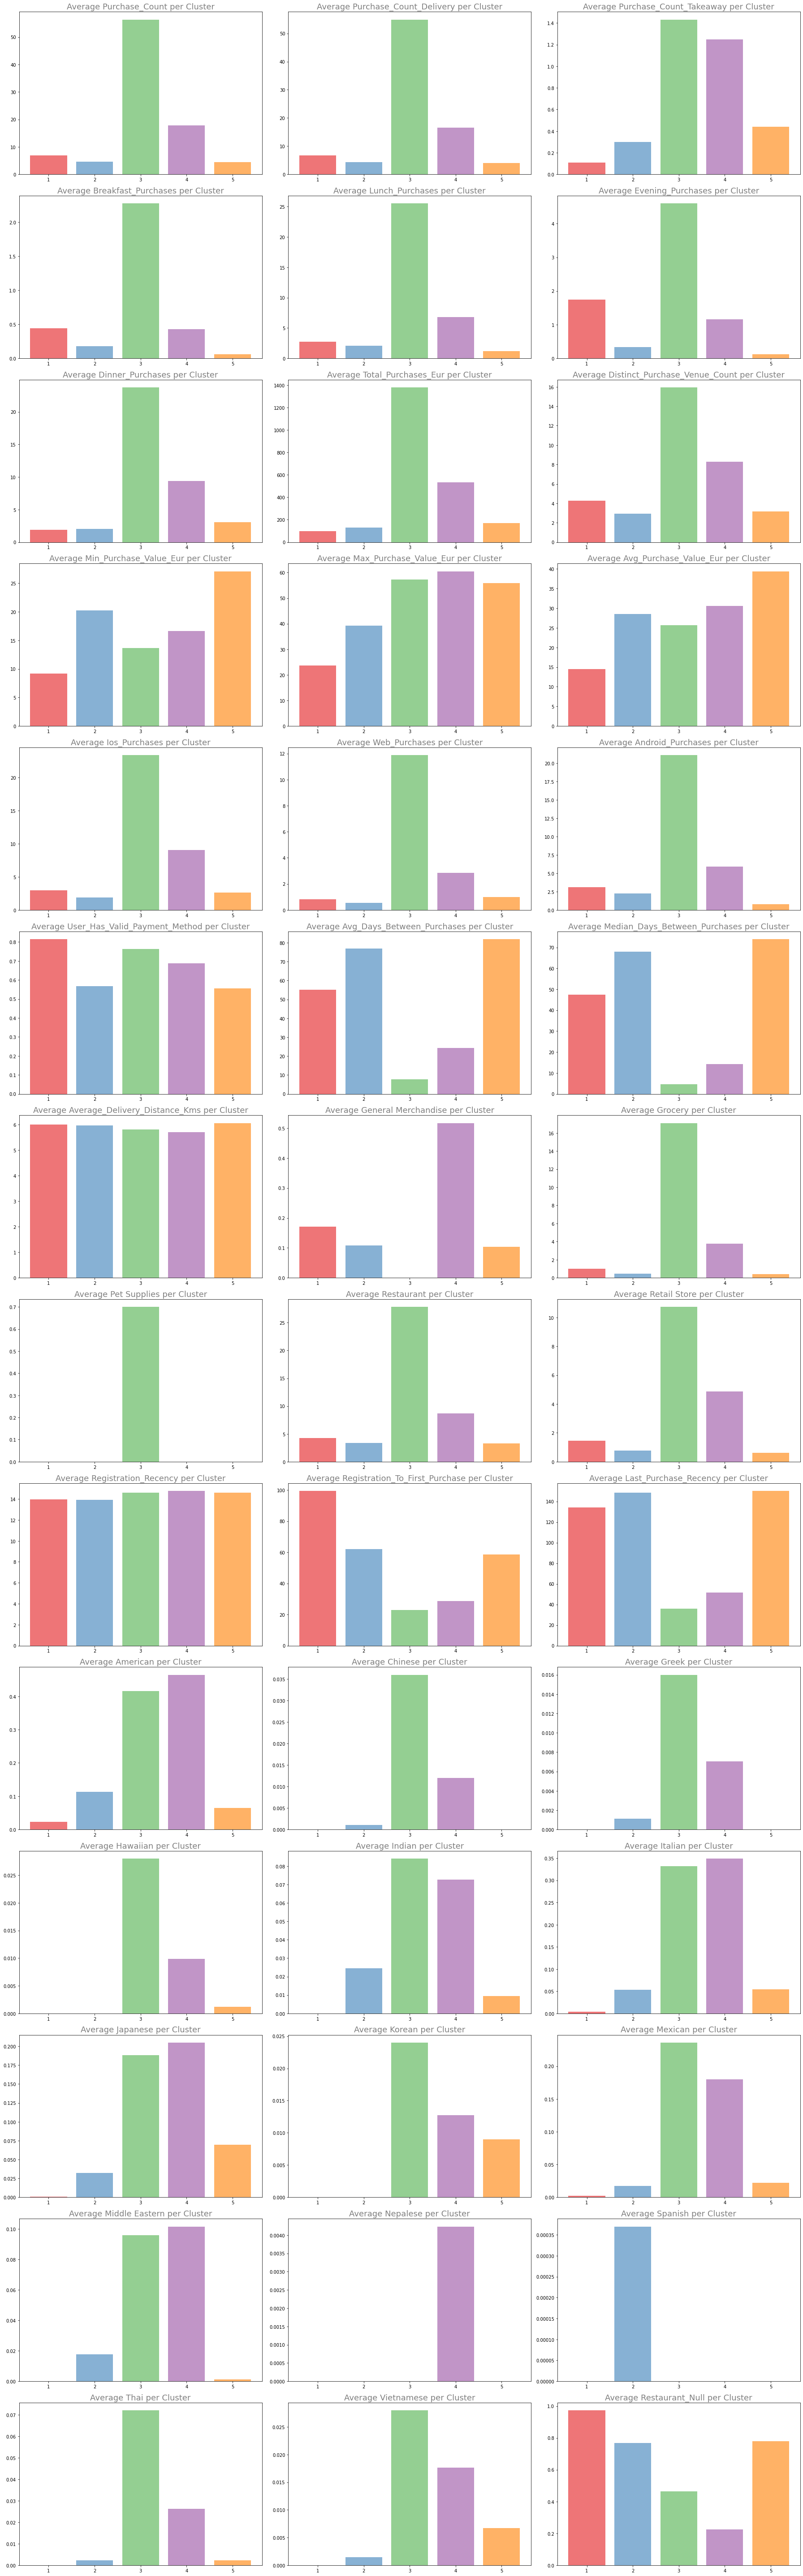

In [86]:
numeric_columns_2 = data_2_merged.select_dtypes(include=np.number).drop(['CLUSTER'], axis=1).columns

fig = plt.figure(figsize=(25, 80))
for i, column in enumerate(numeric_columns_2):
    df_plot = data_2_merged.groupby('CLUSTER')[column].mean()
    ax = fig.add_subplot(14, 3, i+1)

    ax.bar(df_plot.index, df_plot, color=sns.color_palette('Set1'), alpha=0.6)
    ax.set_title(f'Average {column.title()} per Cluster', alpha=0.5, fontsize = 18)
    ax.xaxis.grid(False)
    
plt.tight_layout()
plt.show()

For the categorical columns, we will plot the percentual distribution of each variable in each cluster. It is also worth noting that the chart will only display the legend of the top 3 registration countries for better visualization.

/var/folders/tl/svtqjw_s0kn4lpthrk3xjwpr0000gn/T/ipykernel_5877/823936839.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(labels)
/var/folders/tl/svtqjw_s0kn4lpthrk3xjwpr0000gn/T/ipykernel_5877/823936839.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(labels)


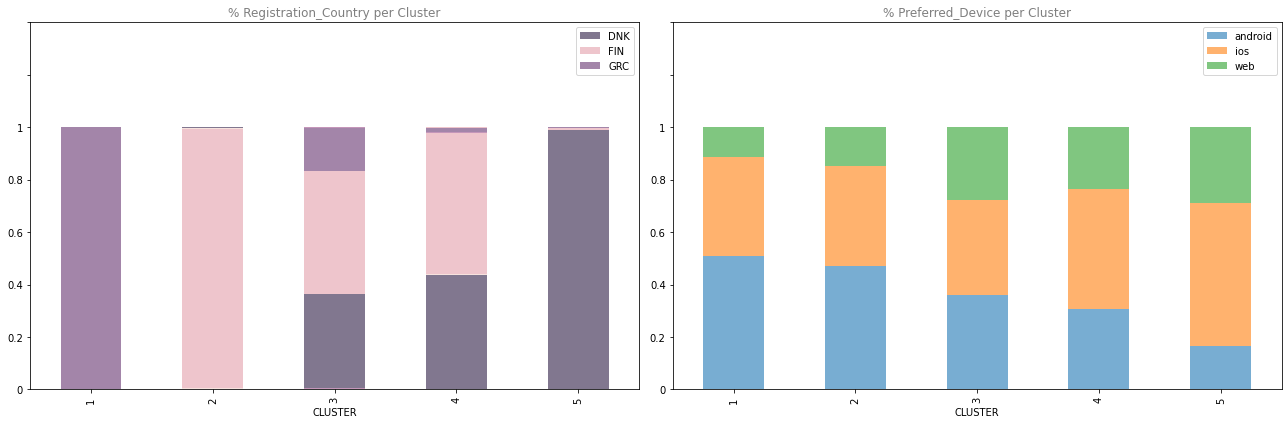

/var/folders/tl/svtqjw_s0kn4lpthrk3xjwpr0000gn/T/ipykernel_5877/823936839.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels(labels)


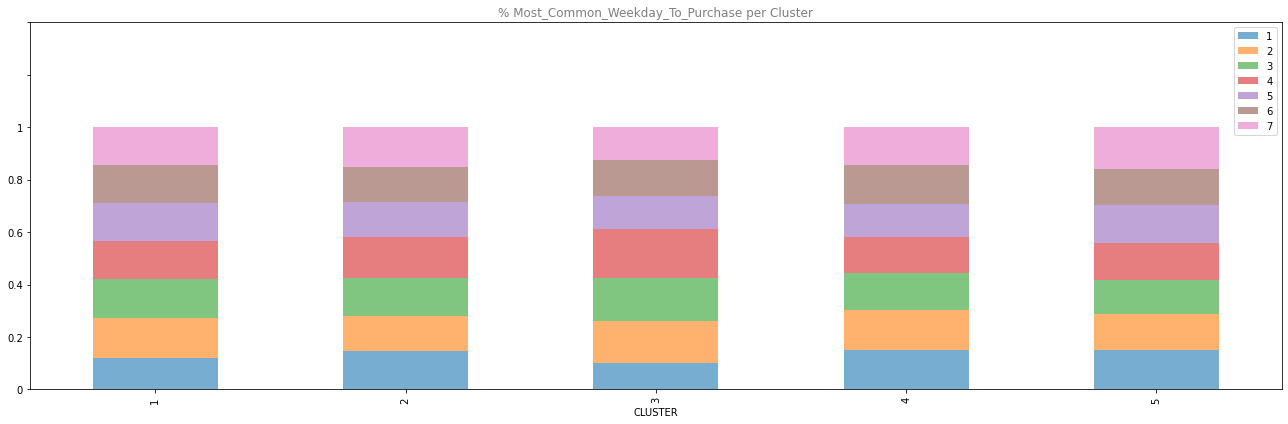

/var/folders/tl/svtqjw_s0kn4lpthrk3xjwpr0000gn/T/ipykernel_5877/823936839.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_yticklabels(labels)


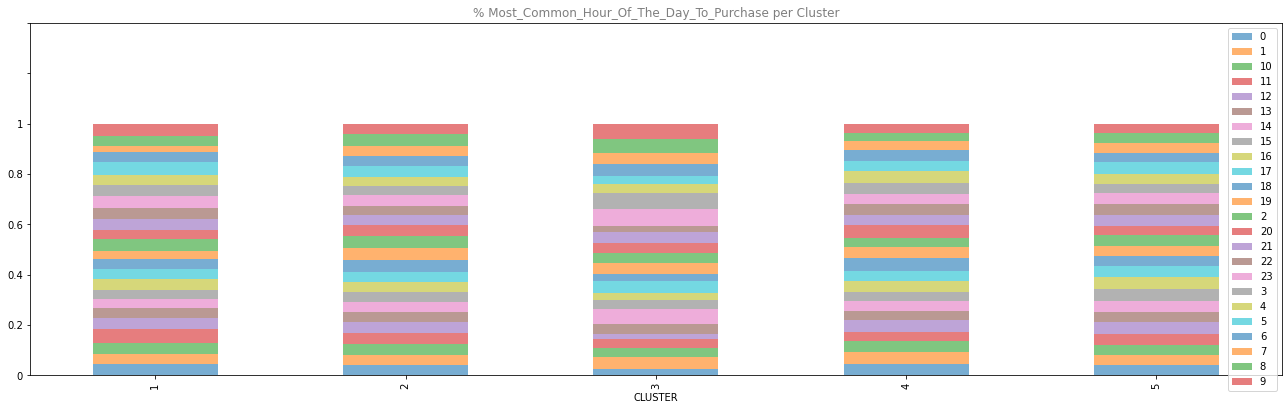

In [87]:
cat_column_3 = ['MOST_COMMON_WEEKDAY_TO_PURCHASE']

cat_column_4 = ['MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE']


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,
                                        figsize=(18,6))
for i, col in enumerate(cat_column_1):
    plot_df = pd.crosstab(index=data_2_merged['CLUSTER'], columns=data_2_merged[col], values=data_2_merged[col], aggfunc='size', normalize='index')
    plot_df.plot.bar(stacked=True, ax=ax1, alpha=0.6, color=sns.cubehelix_palette(hue=1))
    ax1.set_title(f'% {col.title()} per Cluster', alpha=0.5)
    
    handle, label = ax1.get_legend_handles_labels()
    
    chosen_country = [5,7, 10]
    major_handle = [handle[t] for t in chosen_country]
    major_label = [label[t] for t in chosen_country]
    
    ax1.legend(major_handle, major_label)
 
    ax1.set_ylim(0, 1.4)
    ax1.xaxis.grid(False)
   
    labels = [0, 0.2, 0.4, 0.6, 0.8, 1]
    ax1.set_yticklabels(labels)
    
for i, col in enumerate(cat_column_2):
    plot_df = pd.crosstab(index=data_2_merged['CLUSTER'], columns=data_2_merged[col], values=data_2_merged[col], aggfunc='size', normalize='index')
    plot_df.plot.bar(stacked=True, ax=ax2, alpha=0.6)
    ax2.set_title(f'% {col.title()} per Cluster', alpha=0.5)
    
    handle, label = ax2.get_legend_handles_labels()
    
   
    
    ax2.legend(handle, label)
 
    ax2.set_ylim(0, 1.4)
    ax2.xaxis.grid(False)
   
    labels = [0, 0.2, 0.4, 0.6, 0.8, 1]
    ax2.set_yticklabels(labels)

plt.tight_layout()
plt.show()
    

fig, (ax3) = plt.subplots(nrows=1, ncols=1,
                                        figsize=(18,6))    
for i, col in enumerate(cat_column_3):
    plot_df = pd.crosstab(index=data_2_merged['CLUSTER'], columns=data_2_merged[col], values=data_2_merged[col], aggfunc='size', normalize='index')
    plot_df.plot.bar(stacked=True, ax=ax3, alpha=0.6)
    ax3.set_title(f'% {col.title()} per Cluster', alpha=0.5)
    
    handle, label = ax3.get_legend_handles_labels()
    
   
    
    ax3.legend(handle, label)
 
    ax3.set_ylim(0, 1.4)
    ax3.xaxis.grid(False)
   
    labels = [0, 0.2, 0.4, 0.6, 0.8, 1]
    ax3.set_yticklabels(labels)

plt.tight_layout()
plt.show()

 
fig, (ax4) = plt.subplots(nrows=1, ncols=1,
                                        figsize=(18,6))    
for i, col in enumerate(cat_column_4):
    plot_df = pd.crosstab(index=data_2_merged['CLUSTER'], columns=data_2_merged[col], values=data_2_merged[col], aggfunc='size', normalize='index')
    plot_df.plot.bar(stacked=True, ax=ax4, alpha=0.6)
    ax4.set_title(f'% {col.title()} per Cluster', alpha=0.5)
    
    handle, label = ax4.get_legend_handles_labels()
    
    
    ax4.legend(handle, label)
 
    ax4.set_ylim(0, 1.4)
    ax4.xaxis.grid(False)
   
    labels = [0, 0.2, 0.4, 0.6, 0.8, 1]
    ax4.set_yticklabels(labels)

plt.tight_layout()
plt.show()


### 5.5 Description of user clusters considering purchase_count > 1
From the plots in this section, we are going to list the most important characteristics of each cluster of users given that these users made more than one order between September 2019 and October 2020.

**Cluster 1:** 

- Almost all the users come from Greece and prefer using ios (40%) and android (50%) devices.
- Almost all the users did not report their favorite cuisine. About 2% of them reported liking American food
- Over 80% of them have a valid payment method
- On average:
    + Each user made 8 purchases
    + Each user spent about 100 euros (customer lifetime value)
    + Each user spent about 15 euros on each purchase
    + Each user spent a maximum of about 24 euros on each purchase
    + Each user spent a minimum of about 19 euros on each purchase
    + It took them about 100 days since registration to make the first purchase
    + It took them about 55 days to make the next purchase (average days between purchases)
    + the last purchase they made was about 130 days prior to the latest recorded purchase day

**Cluster 2:** 
- Almost all the users come from Finland and prefer using ios (44%) and android (44%) devices.
- About 78% of the users did not report their favorite cuisine. Few of them reported liking American (1,1%), Indian (2%), and Middle Eastern (2%) food
- Only this group reported liking Spanish but just 0.037% of them.
- About 55% of them have a valid payment method
- On average:
    + Each user made 4 purchases
    + Each user spent about 120 euros (customer lifetime value)
    + Each user spent about 28 euros on each purchase
    + Each user spent a maximum of about 40 euros on each purchase
    + Each user spent a minimum of about 20 euros on each purchase
    + It took them about 25 days since registration to make the first purchase
    + It took them about 77 days to make the next purchase (average days between purchases)
    + The last purchase they made was about 32 days prior to the latest recorded purchase day


    

**Cluster 3:**
- Most of the users come from Denmark (38%), Finland (50%), and Greece (11%) and prefer using ios (39%) and android (39%) devices
- About 42% of the users did not report their favorite cuisine. They mainly like American (42%) and Italian food (35%), Japanese (18%), Mexican (23%) food
- This group made grocery, restaurant, and retail store orders much more than the other groups
- Only this group made pet supplies orders and did not make any general merchandise orders. On average, a customer in this group made 0,7 pet supplies order
- About 76% of them have a valid payment method
- On average:
    + Each user made 58 purchases
    + Each user spent about 1400 euros (customer lifetime value)
    + Each user spent about 27 euros on each purchase
    + Each user spent a maximum of about 56 euros on each purchase
    + Each user spent a minimum of about 14 euros on each purchase
    + It took them about 25 days since registration to make the first purchase
    + It took them about 9 days to make the next purchase (average days between purchases)  
    + The last purchase they made was about 32 days prior to the latest recorded purchase day



**Cluster 4:** 
- Most of the users come from Denmark (41%) and Finland (58%), prefer using ios (48%) and android (30%)
- Most of the users did not report their favorite cuisine (80%). Few of them reported liking American (6%), Japanese (7%), and Italian (5%) food
- Only this group reported liking Nepalese food but just 4% of them
- They spent on general merchandise more than the other clusters but mainly spent on restaurants
- About 70% of them have a valid payment method
- On average:
    + Each user made 18 purchases
    + Each user spent about 500 euros (customer lifetime value)
    + Each user spent about 30 euros on each purchase
    + Each user spent a maximum of about 60 euros on each purchase
    + Each user spent a minimum of about 17 euros on each purchase
    + It took them about 30 days since registration to make the first purchase
    + It took them about 22 days to make the next purchase (average days between purchases)
    + The last purchase they made was about 50 days prior to the latest recorded purchase day


**Cluster 5:** 
- Most of the users come from Denmark (98%) and prefer using ios (60%) and web (25%)
- Most of the users reported their favorite cuisine (80%). They mainly like American (43%) and Italian food (35%)
- About 55% of them have a valid payment method
- On average:
    + Each user made 4 purchases
    + Each user spent about 180 euros (customer lifetime value)
    + Each user spent about 39 euros on each purchase
    + Each user spent a maximum of about 58 euros on each purchase
    + Each user spent a minimum of about 16 euros on each purchase
    + It took them about 61 days since registration to make the first purchase
    + It took them about 81 days to make the next purchase (average days between purchases) 
    + The last purchase they made was about 150 days prior to the latest recorded purchase day



## VI. Conclusion on user segmentation

While analyzing data, we noticed that there are no clear differences in 
**MOST_COMMON_WEEKDAY_TO_PURCHASE, 
MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE, 
REGISTRATION_RECENCY, 
and AVERAGE_DELIVERY_DISTANCE_KMS**. 
In other words, all user clusters share the same pattern of these variables.

In total, we have 13 user clusters with three main groups:

### Group 1. Users did not make any purchases between September 2019 and October 2020:

**Cluster 1:** Users are mostly from Denmark and use ios devices. Almost none of them have a valid payment method

**Cluster 2:** Users are mostly from Finland and use android devices. Almost none of them have a valid payment 

**Cluster 3:** Users are mostly from Greece and use android devices. Almost none of them have a valid payment 


### Group 2. Users made only one purchase between September 2019 and October 2020:

All users across clusters in this group made restaurant orders, mainly lunch and dinner purchases.

**Cluster 1:** 
- Most of the users come from Denmark (50%), Finland (40%), and Greece (9%), prefer using ios devices (98%), and made purchases with this medium (100%). 
- About half of them have a valid payment method
- They only made delivery purchases (no takeaway at all)
- On average:
    + they spent about 33 euros per purchase 
    + it took them about 25 days since registration to make the first and only purchase
    + the last and only purchase they made was about 380 days prior to the latest recorded purchase day
    

**Cluster 2:** 

- Most of the users come from Denmark (19%), Finland (60%), and Greece (19%), prefer using android (96%), and made purchases with this medium (100%)
- About a quarter of them have a valid payment method
- They only made delivery purchases (no takeaway at all)
- On average:
    + they spent about 27 euros per purchase 
    + it took them about 30 days since registration to make the first and only purchase
    + the last and only purchase they made was about 375 days prior to the latest recorded purchase day

**Cluster 3:**
- Most of the users come from Denmark (35%), Finland (43%), and Greece (20%), prefer using ios (55%) and android (40%) devices, and made purchases with these media (90%). 
- About half of them have a valid payment method
- They only made delivery purchases (no takeaway at all)
- On average:
    + they spent about 30 euros per purchase 
    + it took them about 330 days since registration to make the first and only purchase
    + the last and only purchase they made was about 80 days prior to the latest recorded purchase day




**Cluster 4:** 
- Most of the users come from Denmark (52%), Finland (38%), and Greece (9%), prefer using web (92%), and made purchases with this medium (98%). 
- All of them have a valid payment method
- They only made delivery purchases (no takeaway at all)
- On average:
    + they spent about 40 euros per purchase 
    + it took them about 25 days since registration to make the first and only purchase
    + the last and only purchase they made was about 380 days prior to the latest recorded purchase day



**Cluster 5:** 
- Most of the users come from Denmark (55%), Finland (38%), and Greece (6%), prefer using ios (50%) and android (30%) devices, and made purchases with these media (75%). 
- About half of them have a valid payment method
- They only made takeaway purchases (no delivery at all)
- On average:
    + they spent about 33 euros per purchase 
    + it took them about 100 days since registration to make the first and only purchase
    + the last and only purchase they made was about 300 days prior to the latest recorded purchase day

    
### Group 3. Users made more than one purchase between September 2019 and October 2020:

All clusters in this group share a common characteristic: most of the orders are restaurant orders (mainly lunch and dinner purchases), followed by grocery and retail store orders.

**Cluster 1:** 

- Almost all the users come from Greece and prefer using ios (40%) and android (50%) devices.
- Almost all the users did not report their favorite cuisine. About 2% of them reported liking American food
- Over 80% of them have a valid payment method
- On average:
    + Each user made 8 purchases
    + Each user spent about 100 euros (customer lifetime value)
    + Each user spent about 15 euros on each purchase
    + Each user spent a maximum of about 24 euros on each purchase
    + Each user spent a minimum of about 19 euros on each purchase
    + It took them about 100 days since registration to make the first purchase
    + It took them about 55 days to make the next purchase (average days between purchases)
    + The last purchase they made was about 130 days prior to the latest recorded purchase day

**Cluster 2:** 
- Almost all the users come from Finland and prefer using ios (44%) and android (44%) devices.
- About 78% of the users did not report their favorite cuisine. Few of them reported liking American (1,1%), Indian (2%), and Middle Eastern (2%) food
- Only this group reported liking Spanish but just 0.037% of them.
- About 55% of them have a valid payment method
- On average:
    + Each user made 4 purchases
    + Each user spent about 120 euros (customer lifetime value)
    + Each user spent about 28 euros on each purchase
    + Each user spent a maximum of about 40 euros on each purchase
    + Each user spent a minimum of about 20 euros on each purchase
    + It took them about 25 days since registration to make the first purchase
    + It took them about 77 days to make the next purchase (average days between purchases)  
    + The last purchase they made was about 32 days prior to the latest recorded purchase day


    

**Cluster 3:**
- Most of the users come from Denmark (38%), Finland (50%), and Greece (11%) and prefer using ios (39%) and android (39%) devices
- About 42% of the users did not report their favorite cuisine. They mainly like American (42%) and Italian food (35%), Japanese (18%), Mexican (23%) food
- This group made grocery, restaurant, and retail store orders much more than the other groups
- Only this group made pet supplies orders and did not make any general merchandise orders. On average, a customer in this group made 0,7 pet supplies order
- About 76% of them have a valid payment method
- On average:
    + Each user made 58 purchases
    + Each user spent about 1400 euros (customer lifetime value)
    + Each user spent about 27 euros on each purchase
    + Each user spent a maximum of about 56 euros on each purchase
    + Each user spent a minimum of about 14 euros on each purchase
    + It took them about 25 days since registration to make the first purchase
    + It took them about 9 days to make the next purchase (average days between purchases)
    + The last purchase they made was about 32 days prior to the latest recorded purchase day



**Cluster 4:** 
- Most of the users come from Denmark (41%) and Finland (58%), prefer using ios (48%) and android (30%)
- Most of the users did not report their favorite cuisine (80%). Few of them reported liking American (6%), Japanese (7%), and Italian (5%) food
- Only this group reported liking Nepalese food but just 4% of them
- They spent on general merchandise more than the other clusters but mainly spent on restaurants
- About 70% of them have a valid payment method
- On average:
    + Each user made 18 purchases
    + Each user spent about 500 euros (customer lifetime value)
    + Each user spent about 30 euros on each purchase
    + Each user spent a maximum of about 60 euros on each purchase
    + Each user spent a minimum of about 17 euros on each purchase
    + It took them about 30 days since registration to make the first purchase
    + It took them about 22 days to make the next purchase (average days between purchases)
    + The last purchase they made was about 50 days prior to the latest recorded purchase day


**Cluster 5:** 
- Most of the users come from Denmark (98%) and prefer using ios (60%) and web (25%)
- Most of the users reported their favorite cuisine (80%). They mainly like American (43%) and Italian food (35%)
- About 55% of them have a valid payment method
- On average:
    + Each user made 4 purchases
    + Each user spent about 180 euros (customer lifetime value)
    + Each user spent about 39 euros on each purchase
    + Each user spent a maximum of about 58 euros on each purchase
    + Each user spent a minimum of about 16 euros on each purchase
    + It took them about 61 days since registration to make the first purchase
    + It took them about 81 days to make the next purchase (average days between purchases)
    + The last purchase they made was about 150 days prior to the latest recorded purchase day






## VII. Business implications

- We should focus on group 3 since users in this group are frequent customers of the company. 
- Especially, we should focus more on the most profitable and frequent customer cluster, which is cluster 3 in group 3. For example, we can send them loyalty discounts for restaurant (especially American, Italian, and Mexican foods for lunch or dinner), grocery, or retail store orders to enhance their satisfaction and encourage them to buy more.
- We should focus on users from Finland and Denmark since they comprise a major proportion of the most profitable clusters.
- Other less profitable and frequent clusters are clusters 2 and 5 in group 3. We can encourage them to make purchases more frequently by giving them lunch/dinner discounts on American or Italian food orders.
